run with `sch_hae_scan/jupterlab_popstrucure` env

In [2]:
import os
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import statistics
import pandas as pd
import allel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from itertools import combinations
from collections import defaultdict
import numpy as np
import vcf
from haversine import haversine
from skbio.stats.distance import mantel
import glob
from tqdm import tqdm
import pickle

In [3]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)

os.chdir(proj_dir)

# PCA

only include ingroup samples to keep things simple and clean

In [4]:
Path("{}/pca".format(results_dir)).mkdir(parents=True, exist_ok=True)

Calculate PCA

In [15]:
%%bash 
echo """guineensis_saotome_ERR119612
intercalatum_drcongo_ERR119613
margrebowiei_zambia_ERR310940
matthei_zambia_ERR103051""" >results/pca/outgroups.list

In [ ]:
%%bash

plink \
    --vcf results/filter_genotypes/maf05_ld_filtered.vcf \
    --pca \
    --double-id \
    --remove results/pca/outgroups.list \
    --allow-extra-chr \
    --out results/pca/pca

In [7]:
#get eigen values and sample labels
pca_df=pd.read_csv("{}/pca/pca.eigenvec".format(results_dir), sep=" ", header=None)
pca_df.columns=["sample_name", "x"] + list(range(1, 21))
pca_df=pca_df.drop("x", axis=1)

# #now add sample info (including location data)
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

#merge the dataframes
pca_df=pca_df.merge(info_df, how='left', on='sample_name')

#fix the country which contains some float NaNs
pca_df["country"] = pca_df["country"].astype(str)

#set marker colors based on the country (limit to 20)
colors={}

i=0

countries = sorted(pca_df["country"].unique().astype(str))

for country in countries:
    colors[country]=cm.tab20(i)
    i+=1

#set marker shapes based on PRESUMED species
markers = { 's_haematobium'  : "o", 
            's_sp'           : "v",
            's_bovis'        : "X",
            's_intercalatum' : "*", 
            's_guiniensis'   : "*",
            's_margrebowiei' : "*", 
            's_matthei'      : "*",}

In [8]:
pca_df

,sample_name,1,2,3,4,5,6,7,8,9,...,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon
0,Sb_NG_au_1.2,-0.175799,0.021560,0.000720,-0.002478,-0.020618,-0.027404,-0.063030,-0.015526,-0.015218,...,SRR11861482,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
1,Sb_NG_au_2.10,-0.175016,0.020865,0.000776,-0.003904,-0.021846,-0.027805,-0.066215,-0.014804,-0.015169,...,SRR11861474,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
2,Sb_NG_au_2.13,-0.175461,0.021140,0.000349,-0.000801,-0.021341,-0.028877,-0.067845,-0.014848,-0.016561,...,SRR11861472,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
3,Sb_NG_au_2.5,-0.174899,0.020970,0.001743,0.001811,-0.020218,-0.029011,-0.065938,-0.015048,-0.012381,...,SRR11861479,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
4,Sb_NG_au_2.6,-0.174146,0.021466,0.000112,-0.003997,-0.022140,-0.029556,-0.068161,-0.015353,-0.018316,...,SRR11861478,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,ssp_niger_libore_167,0.024926,-0.074494,-0.006953,0.049062,0.119446,-0.039909,-0.001459,-0.055951,0.039235,...,SRR11907494,s_sp,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110
166,ssp_niger_libore_168,0.026211,-0.078372,-0.021366,0.068691,-0.053670,0.000618,0.014647,-0.014761,-0.069401,...,SRR11907493,s_sp,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110
167,ssp_niger_libore_169,0.027447,-0.075098,-0.024459,0.056020,-0.052452,-0.008765,0.016217,-0.024511,-0.042898,...,SRR11907492,s_sp,niger,na,snail,unk,scan_africa,genome,13.404170,2.188020
168,ssp_niger_libore_173,0.029647,-0.084856,-0.007566,0.079486,-0.071000,0.021427,0.075533,-0.106260,-0.200325,...,SRR11907488,s_sp,niger,na,snail,unk,scan_africa,genome,13.404170,2.188020


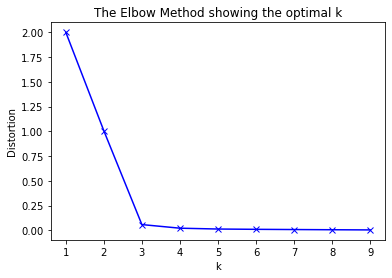

In [9]:
#code modified from https://predictivehacks.com/k-means-elbow-method-code-for-python/

#get pc1,pc2
pc1_pc2=pca_df.iloc[:,1:3].values.tolist()

distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pc1_pc2)
    distortions.append(kmeanModel.inertia_)
    
    
plt.figure()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.savefig("results/pca/kmeans_elbow.png", dpi=300)
plt.savefig("results/pca/kmeans_elbow.svg")

plt.show()

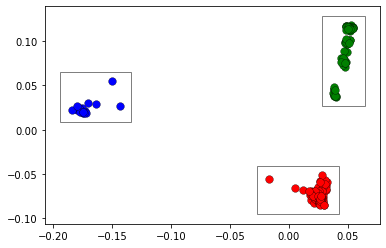

In [10]:
fig, ax = plt.subplots()

#visualize the three groups
kmeans=KMeans(n_clusters=3, random_state=0).fit_predict(pc1_pc2)
pca_df["kmeans_group"]=kmeans
pca_df.to_csv("results/pca/pca_df.csv", index=False, sep=",", header=True, mode='w', na_rep='NaN')

k_colors={0:"red", 1:"green", 2:"blue" }

for index, row in pca_df.iterrows():
    x=row[1]
    y=row[2]
    color=k_colors[kmeans[index]]
    plt.scatter(x, y, color=color, edgecolor="black", linewidths=0.3, s=60)
    

#add rectangles
for k in [0,1,2]:
    x1=pca_df[pca_df["kmeans_group"]==k][1].min()
    x2=pca_df[pca_df["kmeans_group"]==k][1].max()

    y1=pca_df[pca_df["kmeans_group"]==k][2].min()
    y2=pca_df[pca_df["kmeans_group"]==k][2].max()

    rect = mpatches.Rectangle((x1-.01, y1-.01), (x2-x1)+.02, (y2-y1)+.02, linewidth=1, edgecolor='grey', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

#draw circles around kmeans groupsPath("{}/pca".format(results_dir)).mkdir(parents=True, exist_ok=True)

so based off this info I think that anything in group 0 or 1 (red or green) is a Sh and anything in blue is a Sb.
Update the df accordingly to indicate `pca_species`.

In [11]:
pca_species = {0: "s_haematobium",
               1: "s_haematobium",
               2: "s_bovis"}

In [12]:
pca_df["pca_species"] = str("Na")

for index, row in pca_df.iterrows():
    pca_df.at[index,"pca_species"] = pca_species[row["kmeans_group"]]

pca_df.to_csv("results/pca/pca_df.csv", index=False, sep=",", header=True, mode='w', na_rep='NaN')

pca_df

,sample_name,1,2,3,4,5,6,7,8,9,...,country,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species
0,Sb_NG_au_1.2,-0.175799,0.021560,0.000720,-0.002478,-0.020618,-0.027404,-0.063030,-0.015526,-0.015218,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
1,Sb_NG_au_2.10,-0.175016,0.020865,0.000776,-0.003904,-0.021846,-0.027805,-0.066215,-0.014804,-0.015169,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
2,Sb_NG_au_2.13,-0.175461,0.021140,0.000349,-0.000801,-0.021341,-0.028877,-0.067845,-0.014848,-0.016561,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
3,Sb_NG_au_2.5,-0.174899,0.020970,0.001743,0.001811,-0.020218,-0.029011,-0.065938,-0.015048,-0.012381,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
4,Sb_NG_au_2.6,-0.174146,0.021466,0.000112,-0.003997,-0.022140,-0.029556,-0.068161,-0.015353,-0.018316,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,ssp_niger_libore_167,0.024926,-0.074494,-0.006953,0.049062,0.119446,-0.039909,-0.001459,-0.055951,0.039235,...,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium
166,ssp_niger_libore_168,0.026211,-0.078372,-0.021366,0.068691,-0.053670,0.000618,0.014647,-0.014761,-0.069401,...,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium
167,ssp_niger_libore_169,0.027447,-0.075098,-0.024459,0.056020,-0.052452,-0.008765,0.016217,-0.024511,-0.042898,...,niger,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium
168,ssp_niger_libore_173,0.029647,-0.084856,-0.007566,0.079486,-0.071000,0.021427,0.075533,-0.106260,-0.200325,...,niger,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium


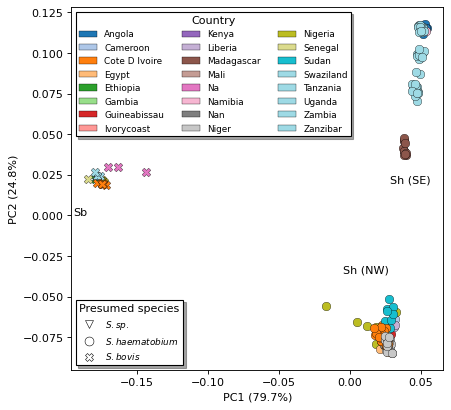

In [13]:
#plot the results
#fig, ax = plt.subplots()
figure(figsize=(6, 6), dpi=80)

#figure(figsize=(6,6))

for index, row in pca_df.iterrows():
    x=row[1]
    y=row[2]
    marker=markers[row["pca_species"]]
    color=colors[row["country"]]
    
    plt.scatter(x, y, marker=marker, color=color, edgecolor="black", linewidths=0.3, s=60)
    
# #set title
# num_snvs="^"
# plt.title("{} SNPs (MAF05, LD)".format(num_snvs))

#set x label (eigen 1)
eigen_vals=[line.strip() for line in open("results/pca/pca.eigenval", 'r')]

pc1=eigen_vals[0]
plt.xlabel("PC1 ({:.1f}%)".format(float(pc1)))

#set x label (eigen 2)
pc2=eigen_vals[1]
plt.ylabel("PC2 ({:.1f}%)".format(float(pc2)))

#add rectangles
for k in [0,1,2]:
    x1=pca_df[pca_df["kmeans_group"]==k][1].min()
    x2=pca_df[pca_df["kmeans_group"]==k][1].max()

    y1=pca_df[pca_df["kmeans_group"]==k][2].min()
    y2=pca_df[pca_df["kmeans_group"]==k][2].max()

    rect = mpatches.Rectangle((x1-.01, y1-.01), (x2-x1)+.02, (y2-y1)+.02, linewidth=1, edgecolor='grey', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)

#make legend for countries
country_patches=[]
for country in colors.keys():
    country_patch=mpatches.Patch(facecolor=colors[country], 
                         edgecolor="black", 
                         label=country.title().replace("_", " "),
                         linewidth=0.3)
    country_patches.append(country_patch)
    
#country_legend = plt.legend(title="Country", handles=country_patches, scatterpoints=1, bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=2)
country_legend = plt.legend(title="Country", handles=country_patches, scatterpoints=1, loc='upper left', ncol=3, prop={'size': 8}, edgecolor="black", fancybox=False, shadow=True)

plt.gca().add_artist(country_legend)

#make legend for species
ssp_marker = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='v',
                          markersize=8, markeredgewidth=0.5, label='${S. sp.}$')
ssh_marker = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white",  marker='o',
                          markersize=8, markeredgewidth=0.5, label='${S. haematobium}$')
ssb_marker = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='X',
                          markersize=8, markeredgewidth=0.5, label='${S. bovis}$')

prop={'size': 8}
#plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker], bbox_to_anchor=(1.05, 0.3))
plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker], loc='lower left', prop={'size': 8}, edgecolor="black", fancybox=False, shadow=True)


#add kmeans group annotation
plt.annotate("Sh (SE)", xy=(0.0282, 0.02))
plt.annotate("Sh (NW)", xy=(-0.005, -0.0353))
plt.annotate("Sb",      xy=(-0.195,   0.0))



#save
plt.savefig("results/pca/pca.png", dpi=300)
plt.savefig("results/pca/pca.svg")

#display
plt.show()
plt.close()

In [14]:
#generate labeles for downstream work
k_pop_labels={0: "sh_nw", 
              1: "sh_se", 
              2: "sb" }

kmeans_labels=[]
for index, row in pca_df.iterrows():
    kmeans_labels.append(k_pop_labels[row["kmeans_group"]])

pca_df["kmeans_label"]=kmeans_labels
pca_df.to_csv("results/pca/pca_df.csv", index=False, sep=",", header=True, mode='w', na_rep='NaN')

# Admixture

In [4]:
Path("{}/admixture".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/admixture".format(results_dir))

In [113]:
%%bash
#thin the vcf file

vcftools \
    --vcf ../filter_genotypes/ingroup_maf05_ld_filtered.vcf \
    --thin 10000 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >ingroup_maf05_ld_filtered_thinned10k.vcf


plink \
    --vcf ingroup_maf05_ld_filtered_thinned10k.vcf \
    --out ingroup_maf05_ld_filtered_thinned10k \
    --double-id \
    --recode12 \
    --allow-extra-chr

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to ingroup_maf05_ld_filtered_thinned10k.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out ingroup_maf05_ld_filtered_thinned10k
  --recode 12
  --vcf ingroup_maf05_ld_filtered_thinned10k.vcf

128540 MB RAM detected; reserving 64270 MB for main workspace.
--vcf: ingroup_maf05_ld_filtered_thinned10k-temporary.bed +
ingroup_maf05_ld_filtered_thinned10k-temporary.bim +
ingroup_maf05_ld_filtered_thinned10k-temporary.fam written.
32581 variants loaded from .bim file.
159 people (0 males, 0 females, 159 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ingroup_maf05_ld_filtered_thinned10k.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 159 founders and 0 nonfounders present.
Calculating allele frequencies.


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../filter_genotypes/ingroup_maf05_ld_filtered.vcf
	--recode-INFO-all
	--thin 10000
	--recode
	--stdout

After filtering, kept 159 out of 159 Individuals
Outputting VCF file...
After filtering, kept 32581 out of a possible 431488 Sites
Run Time = 27.00 seconds


In [4]:
%%bash

head -n 2000 ingroup_maf05_ld_filtered_thinned10k.vcf   \
    | grep "#" \
    | tail -n1 \
    | cut -f10- \
    | sed 's/\t/\n/g' \
    >ingroup_samples.list

In [ ]:
%%bash

#UNSUPERVISED 
#submit jobs to the cluster
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -p -1023"  

for K in $(seq 1 20); do
    CMD="conda activate ~/sch_hae_scan/envs/admixture; admixture \
        --cv=1000 \
        -j12 \
        ingroup_maf05_ld_filtered_thinned10k.ped \
        $K \
        >adm_$K.log"

    echo $CMD | $QSUB -N adm_k$K -o ~/sch_hae_scan/results/logs/adm_k$K.log -pe smp 12
done

In [9]:
%%bash

#get CV scores when jobs are completed
echo "k,cv" >cv_table.csv
for i in $(seq 1 20); do 
    CV=$(grep "CV error" adm_$i.log | rev | cut -f1 -d" "| rev)
    echo "$i,$CV"
done >>cv_table.csv

In [5]:
cv_df=pd.read_csv("cv_table.csv", sep=",") 

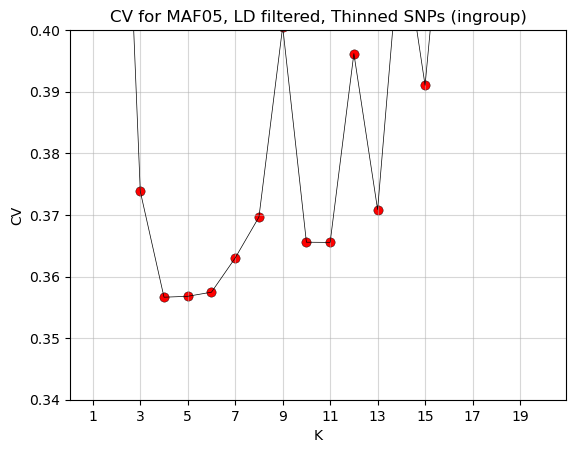

In [20]:
# #plot the cv_table
plt.plot(cv_df["k"], cv_df["cv"], color="black", linewidth=0.5)
plt.scatter(cv_df["k"], cv_df["cv"], 
            marker="o", 
            color="red", 
            edgecolor="black", 
            linewidths=0.3, 
            s=45)
plt.ylim([0.34, 0.4])
plt.xticks(list(range(1,20, 2)))
plt.grid(alpha=0.5)
plt.title("CV for MAF05, LD filtered, Thinned SNPs (ingroup)")
plt.ylabel("CV")
plt.xlabel("K")
plt.savefig("cv.svg")
plt.savefig("cv.png", dpi=300)

plt.show()

In [21]:
xticks=[]
xlabel_pos=[]
xlabel=[]

# for pca_groups in ["s_bovis", "s_haematobium", "s_sp"]:
#     sp_idxs=adm_df.index[adm_df['presumed_species']==species].tolist()
#     xticks.append(min(sp_idxs))
#     #xticks.append(max(sp_idxs))
#     xlabel_pos=statistics.mean(sp_idxs)
#     xlabel.append(species)

for pcak_group in adm_df["kmeans_group"].unique():
    df_idxs=adm_df.index[adm_df['kmeans_group']==pcak_group].tolist()
    xticks.append(min(df_idxs))
    #xticks.append(max(sp_idxs))
    xlabel_pos=statistics.mean(df_idxs)
    xlabel.append(pcak_group)


Based on these results K4-6 are ideal.

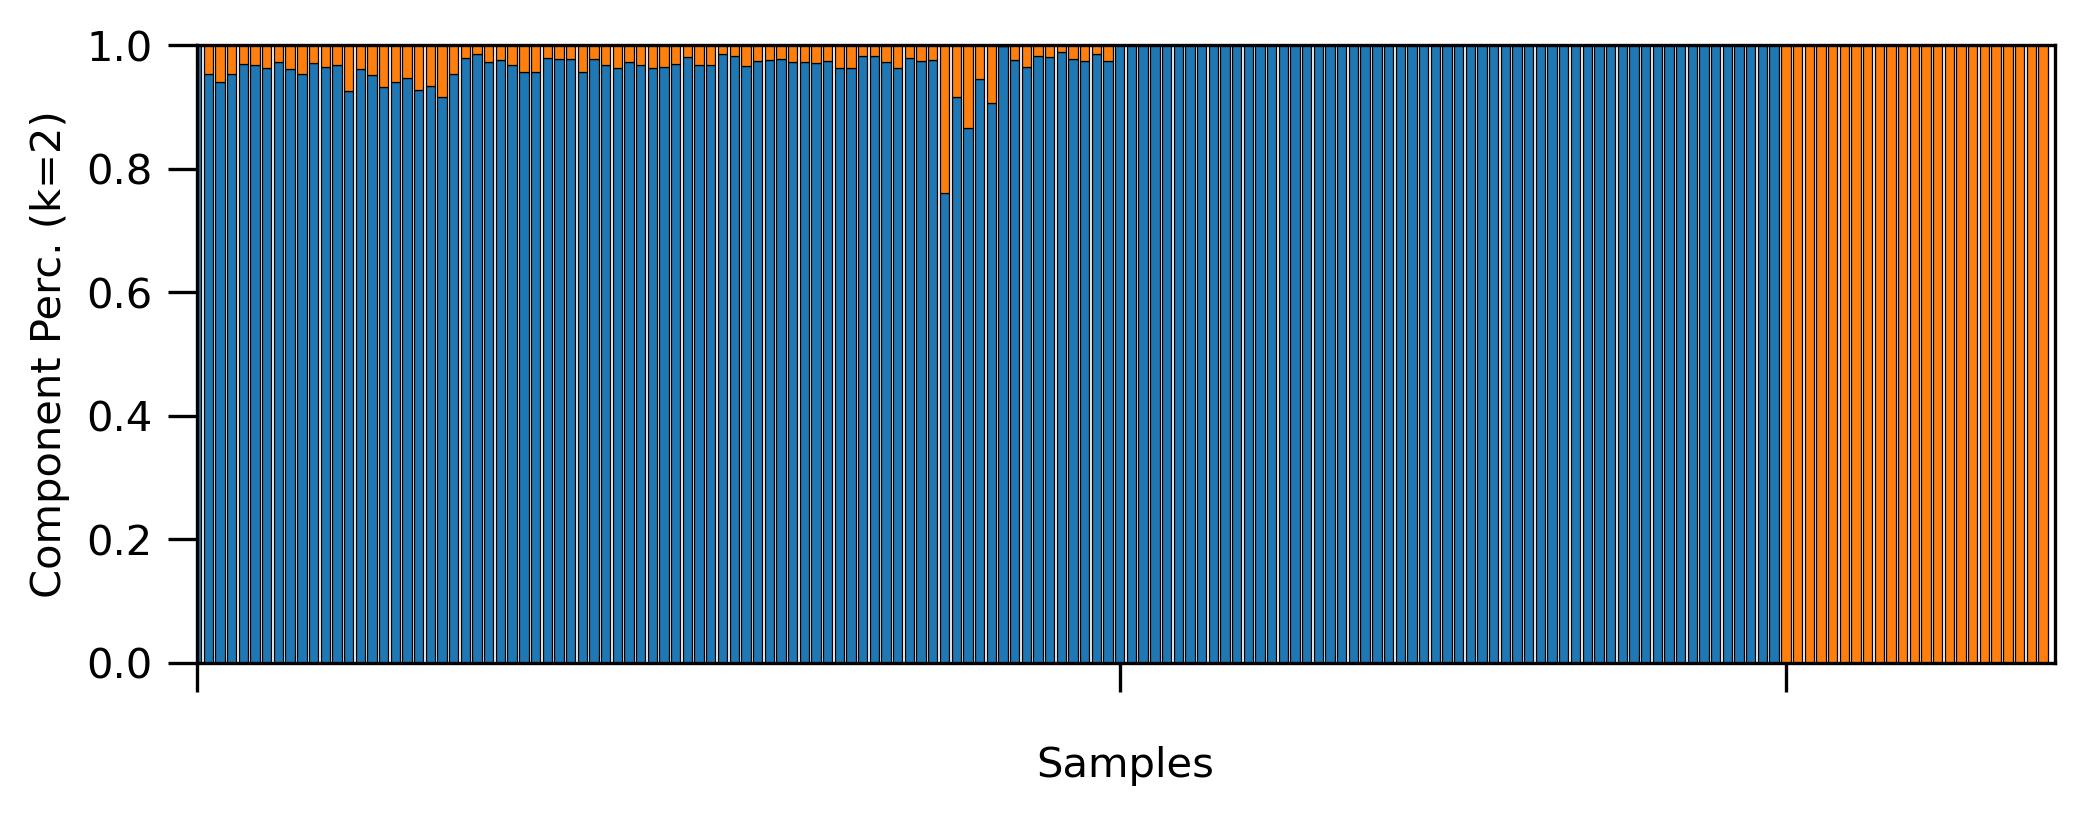

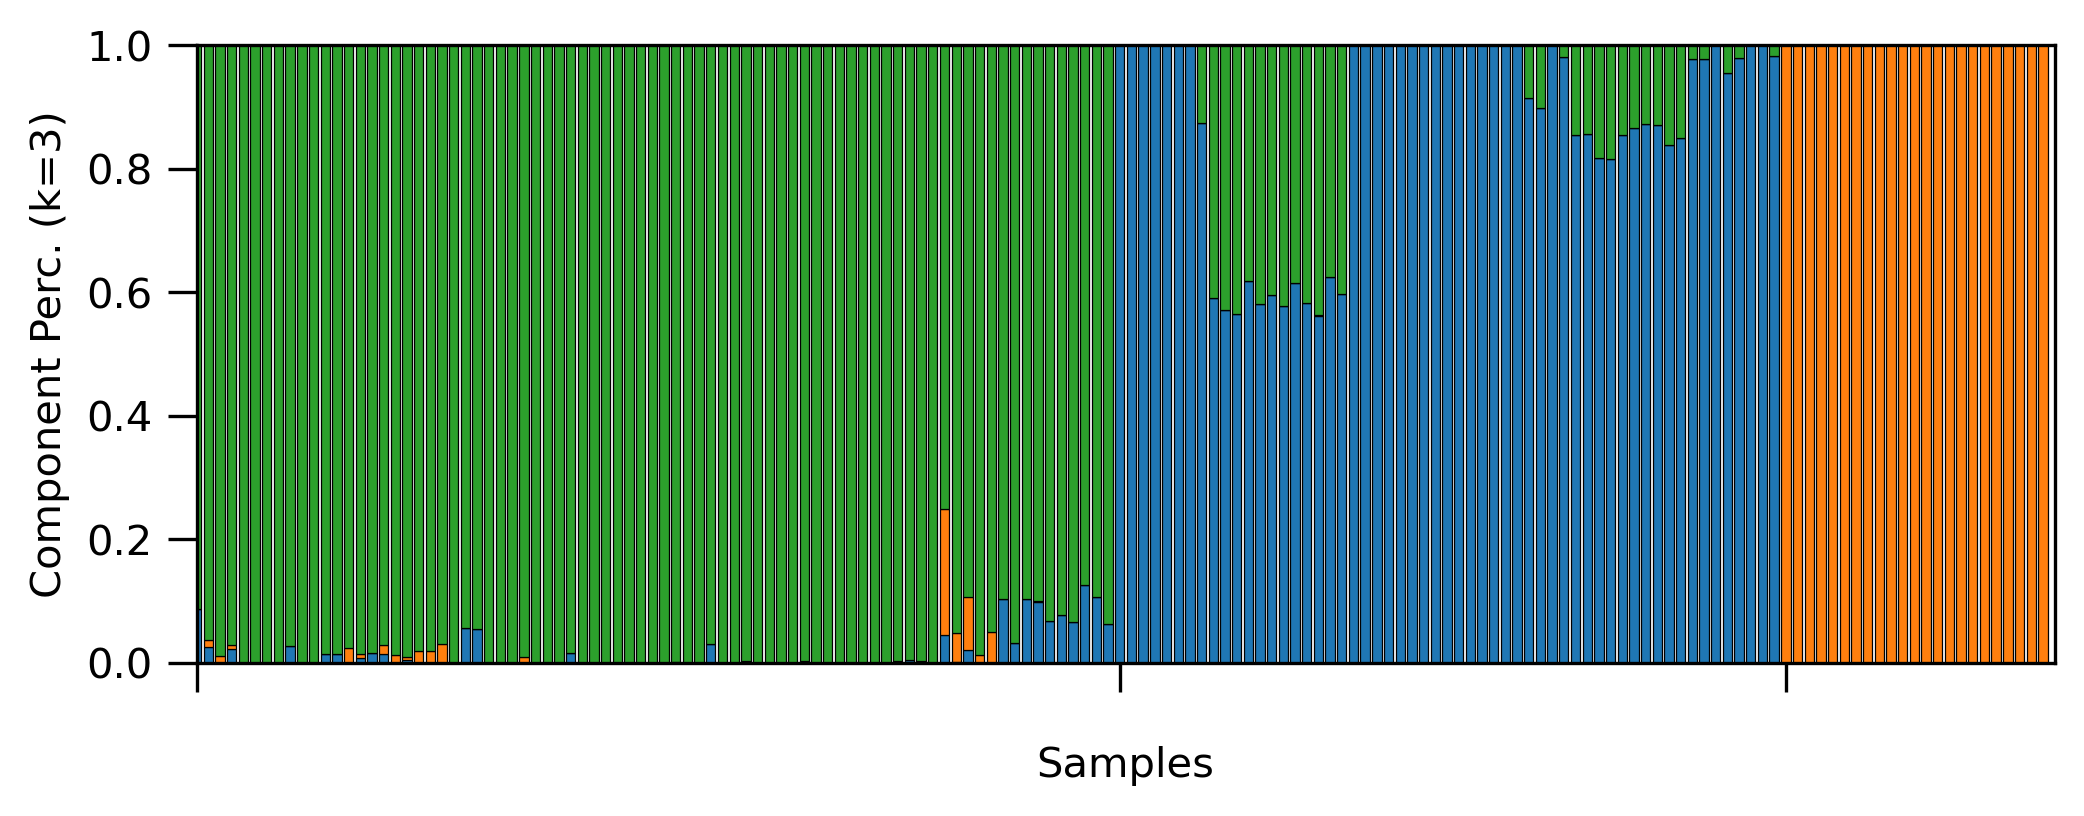

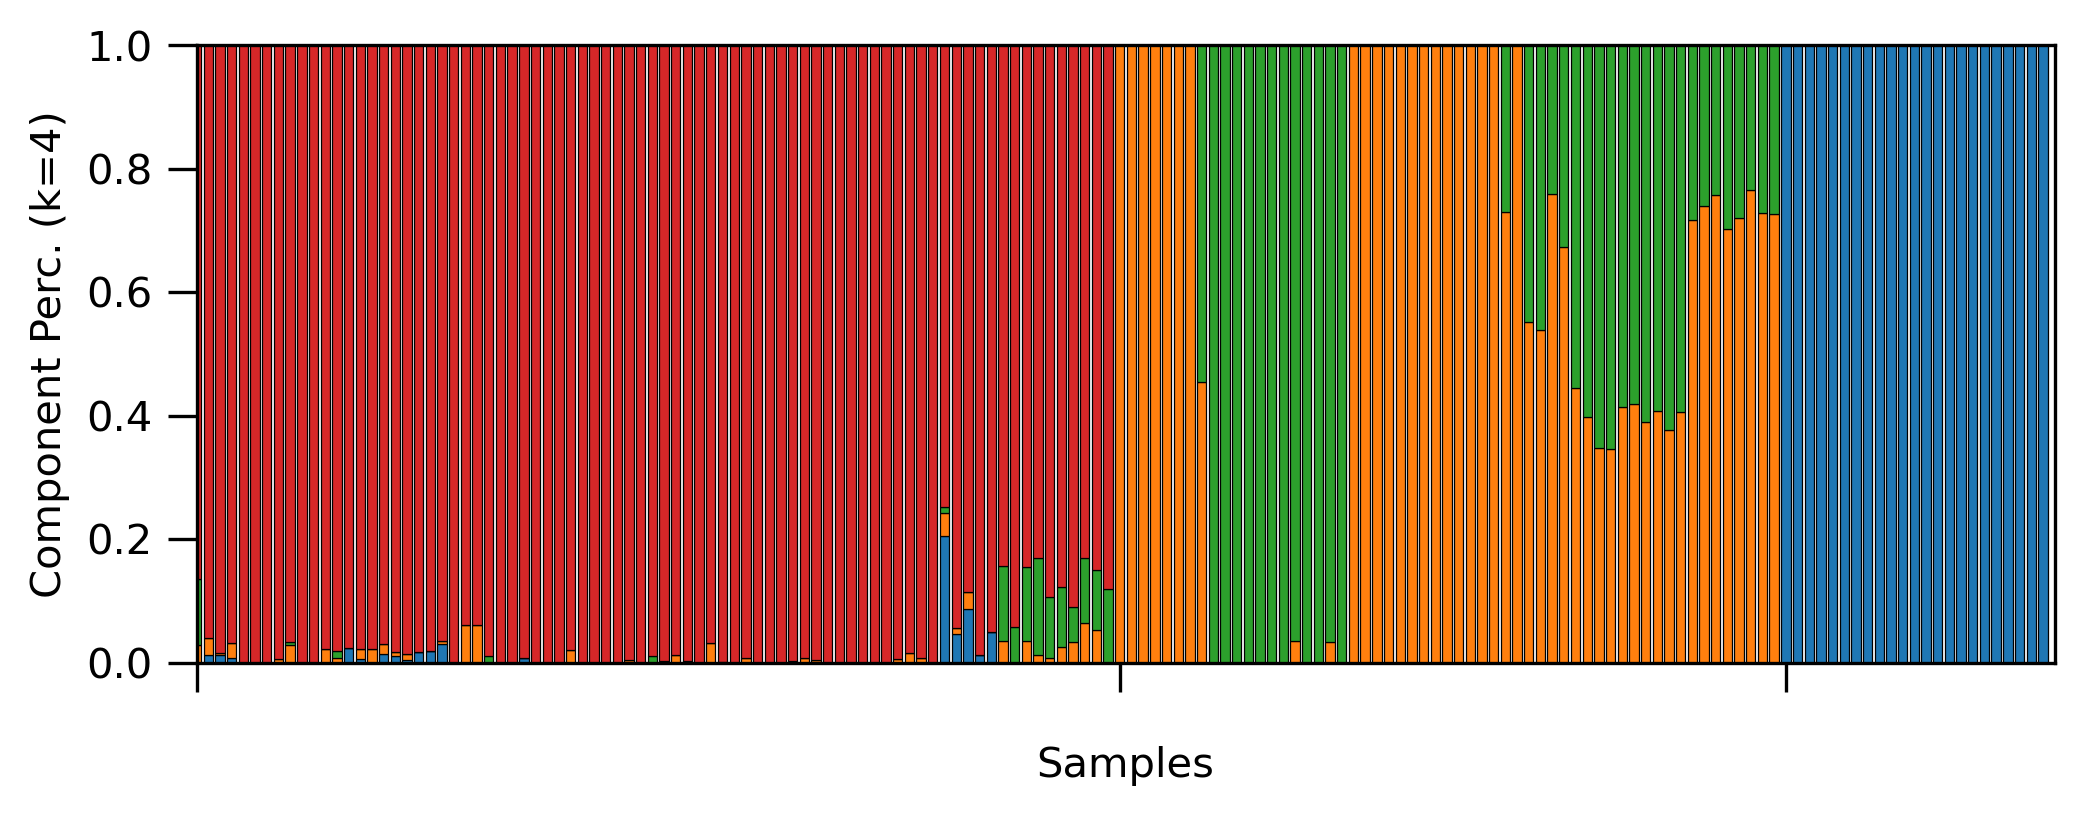

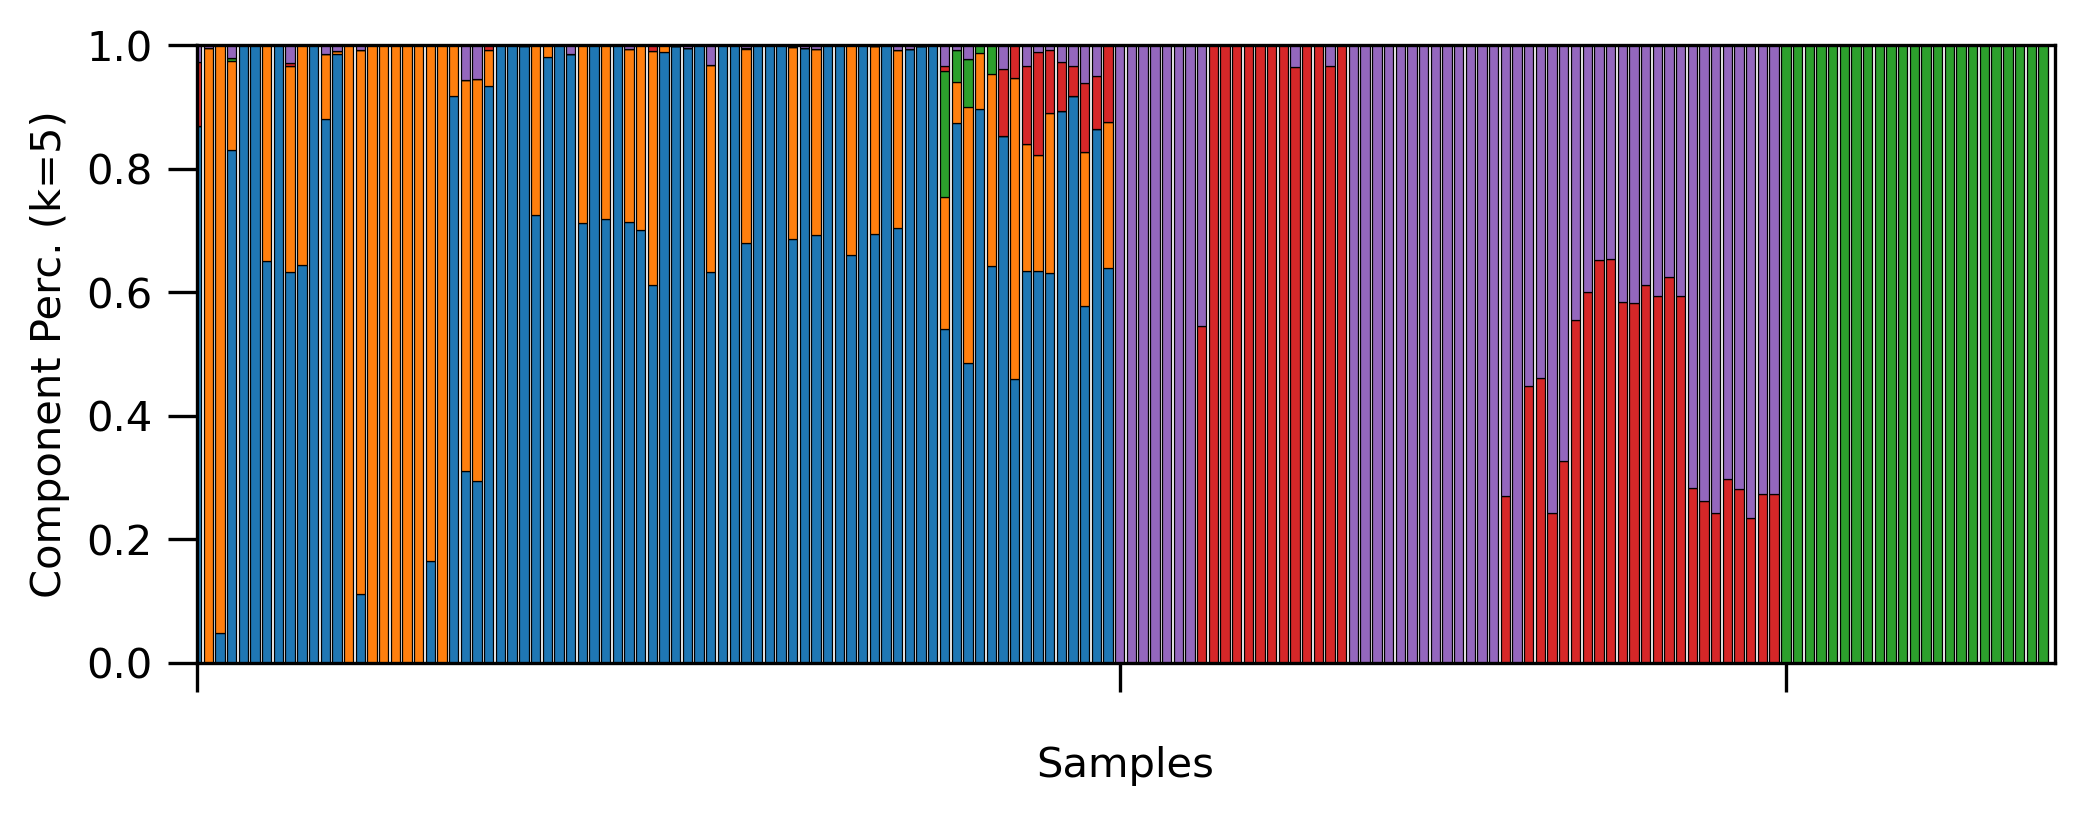

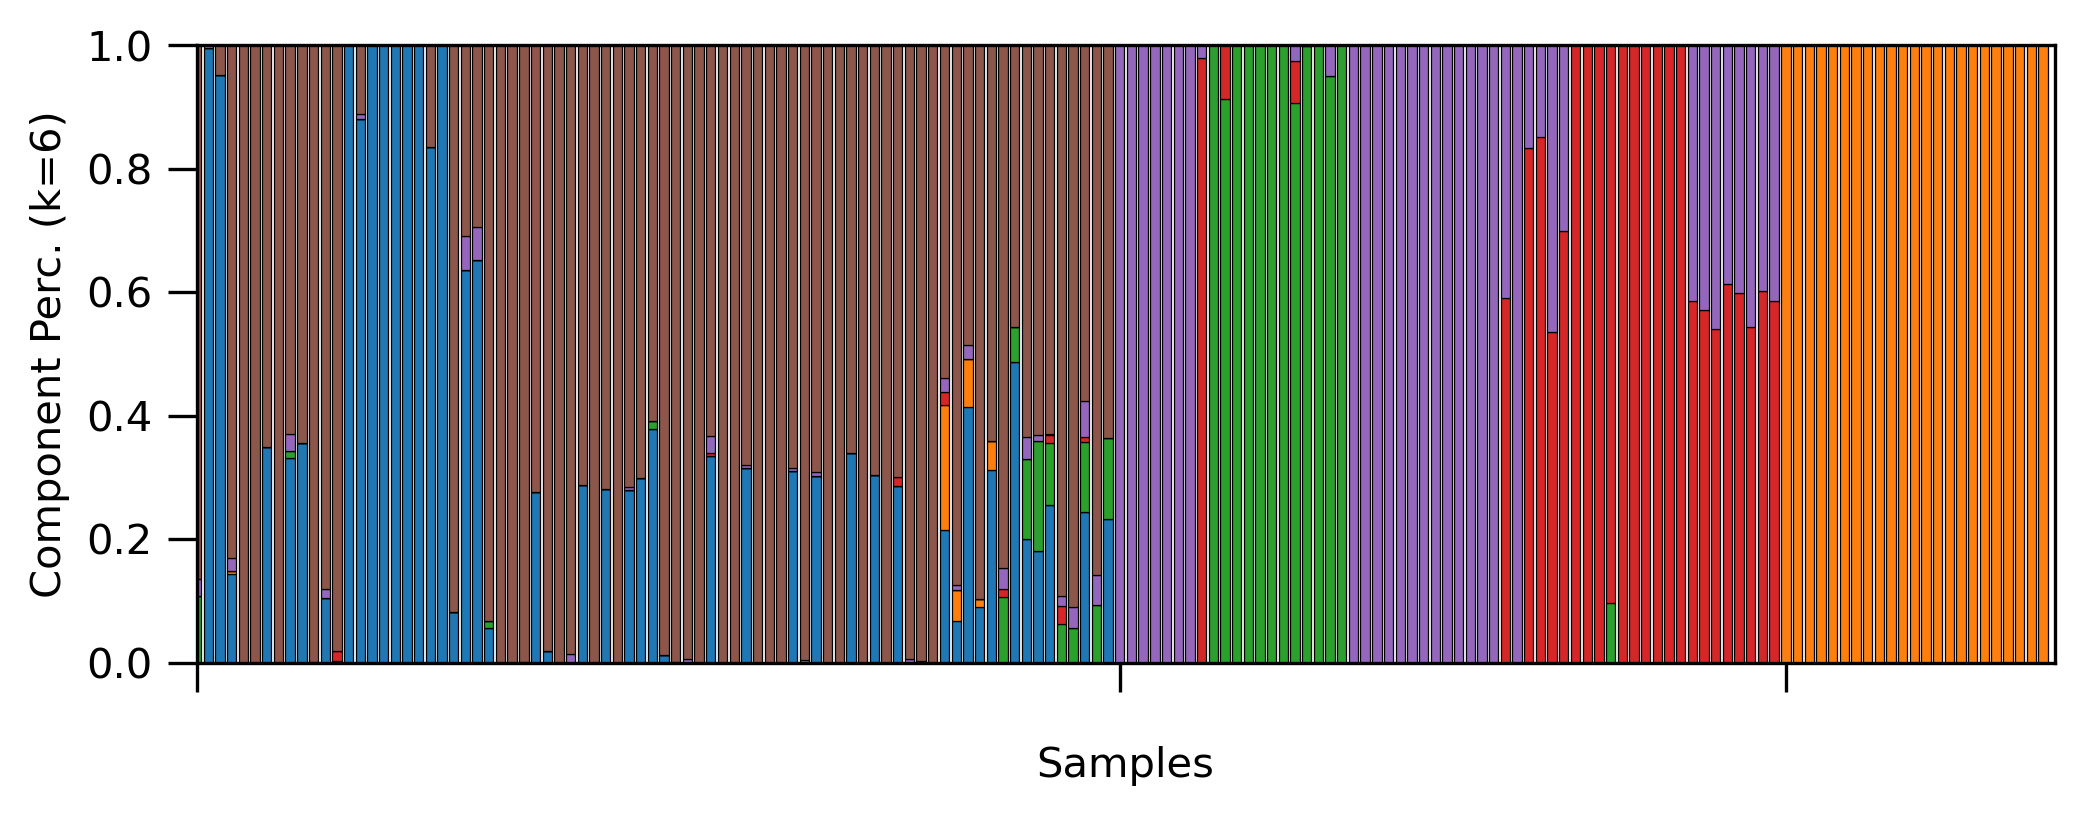

In [37]:
#read in samples
samples=[]
with open("ingroup_samples.list", 'r') as f:
    samples = f.read().splitlines()

#set range of ks to be investigated
ks=[2,3,4,5,6]

for k in ks:
#for k in [4]:
    figure(figsize=(7, 3), dpi=300)

    adm_df=pd.read_csv("ingroup_maf05_ld_filtered_thinned10k.{}.Q".format(k), sep=" ", header=None)
    adm_df["sample_name"]=samples

    x=list(range(0, len(adm_df)))

    info_df=pd.read_csv("../../data/seq_and_sample_docs/all_sh_sb_sample_data.csv", sep=",") 

    #merge the dataframes
    adm_df=adm_df.merge(info_df, how='left', on='sample_name')

    #get pca kmeans groups and add
    pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
    adm_df=adm_df.merge(pca_df[["sample_name", "kmeans_group"]], how='left', on='sample_name')


    #adm_df=adm_df.sort_values(by=["presumed_species", "country"])
    adm_df=adm_df.sort_values(by=["kmeans_group", "country"])
    adm_df=adm_df.reset_index(drop=True)

    bottom=[0]*len(adm_df)
    for p_comp in range(0, k):
        plt.bar(x, adm_df[p_comp], bottom=bottom, edgecolor="black", linewidth=0.3)
        bottom=bottom+adm_df[p_comp]

    #plt.xlabel(adm_df["sample_name"])
    plt.ylabel("Component Perc. (k={})".format(k))
    plt.xlabel("Samples", labelpad=20)
    plt.tight_layout()
    plt.xlim(0,len(adm_df))
    plt.ylim(0,1)
    plt.xticks(xticks)
    plt.tick_params(labelbottom=False, length=7) 
    
    plt.savefig("k{}.svg".format(k))
    plt.savefig("k{}.png".format(k), dpi=600)

    plt.show()
    plt.close()

In [5]:
#read in samples
samples=[]
with open("ingroup_samples.list", 'r') as f:
    samples = f.read().splitlines()

    
k=2
adm_df=pd.read_csv("ingroup_maf05_ld_filtered_thinned10k.{}.Q".format(k), sep=" ", header=None)
adm_df["sample_name"]=samples

x=list(range(0, len(adm_df)))

info_df=pd.read_csv("../../data/seq_and_sample_docs/all_sh_sb_sample_data.csv", sep=",") 

#merge the dataframes
adm_df=adm_df.merge(info_df, how='left', on='sample_name')

#get pca kmeans groups and add
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
adm_df=adm_df.merge(pca_df[["sample_name", "kmeans_group"]], how='left', on='sample_name')


#adm_df=adm_df.sort_values(by=["presumed_species", "country"])
adm_df=adm_df.sort_values(by=["kmeans_group", "country"])
adm_df=adm_df.reset_index(drop=True)

In [6]:
adm_df

,0,1,sample_name,admera_id,barcode_label_ID,library_id,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon,kmeans_group
0,0.999990,0.000010,sh_cameroon_SRR13579883,na,na,na,SRR13579883,s_bovis,cameroon,na,na,bovis,Rey_2019,genome,NaN,NaN,0
1,0.953343,0.046657,sbo_cdivoire_raviart_108,19047FL-14-03-09,MCFEDA1E10294,na,SRR11907393,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0
2,0.940585,0.059415,sbo_cdivoire_raviart_109,19047FL-14-03-10,MCFEDA1E10295,na,SRR11907392,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0
3,0.953541,0.046459,sha_cdivoire_kongobo_115,19047FL-14-03-16,MCFEDA1E10303,na,SRR11907385,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.763982,-5.476109,0
4,0.970059,0.029941,ssp_cdivoire_allokokro_102,19047FL-14-03-03,MCF28EEAF0339,na,SRR11907400,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.751133,-5.091036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0.000010,0.999990,bovis_senegal_SRR13579876,na,na,na,SRR13579876,s_bovis,senegal,na,na,bovis,Rey_2019,genome,NaN,NaN,2
155,0.000010,0.999990,bovis_tanzania_ERR103048,na,na,na,ERR103048,s_bovis,tanzania,na,na,bovis,na,genome,NaN,NaN,2
156,0.000010,0.999990,bovis_tanzania_SRR7867225,na,na,na,SRR7867225,s_bovis,tanzania,na,na,bovis,Rey_2019,genome,NaN,NaN,2
157,0.000010,0.999990,bovis_tanzania_SRR7867226,na,na,na,SRR7867226,s_bovis,tanzania,na,na,bovis,Rey_2019,genome,NaN,NaN,2


In [69]:
adm_df[adm_df["presumed_species"]=="s_bovis"]

,0,1,sample_name,admera_id,barcode_label_ID,library_id,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,kmeans_group
112,0.99999,0.00001,sbo_uganda_runga_44,19047FL-14-01-31,MCF03050E0859,na,SRR11907453,s_bovis,uganda,na,cow,bovis,scan_africa,genome,1
143,0.00001,0.99999,bovis_ethiopia_SRR13579874,na,na,na,SRR13579874,s_bovis,ethiopia,na,na,unk,Rey_2019,genome,2
144,0.00001,0.99999,bovis_keyna_SRR13579878,na,na,na,SRR13579878,s_bovis,kenya,na,na,unk,Rey_2019,genome,2
145,0.00001,0.99999,bovis_tanzania_ERR103048,na,na,na,ERR103048,s_bovis,na,na,na,bovis,na,genome,2
146,0.00001,0.99999,Sb_NG_au_1.2,19047FL-14-05-15,na,Sb.Au.1.2,SRR11861482,s_bovis,nigeria,na,cow,bovis,nigeria,genome,2
147,0.00001,0.99999,Sb_NG_au_2.10,19047FL-14-05-22,na,Sb.Au.2.10,SRR11861474,s_bovis,nigeria,na,cow,bovis,nigeria,genome,2
148,0.00001,0.99999,Sb_NG_au_2.13,19047FL-14-05-24,na,Sb.Au.2.13,SRR11861472,s_bovis,nigeria,na,cow,bovis,nigeria,genome,2
149,0.00001,0.99999,Sb_NG_au_2.5,19047FL-14-05-18,na,Sb.Au.2.5,SRR11861479,s_bovis,nigeria,na,cow,bovis,nigeria,genome,2
150,0.00001,0.99999,Sb_NG_au_2.6,19047FL-14-05-19,na,Sb.Au.2.6,SRR11861478,s_bovis,nigeria,na,cow,bovis,nigeria,genome,2
151,0.00001,0.99999,Sb_NG_be_1.10,19047FL-14-05-03,na,Sb.Be.1.10,SRR11861466,s_bovis,nigeria,na,cow,bovis,nigeria,genome,2


based of the above it is clear that population component 1 is representative of S. bovis

In [72]:
#get samples with super high SB assignment
high_sb_samples=np.array(adm_df[adm_df[1]>=0.999]["sample_name"])

#randomly select half of them to serve on a panel
np.random.shuffle(high_sb_samples)
sb_ref_samples = high_sb_samples[0:int(len(high_sb_samples)*0.75)]

#get samples with super high SB assignment
low_sb_samples=np.array(adm_df[adm_df[1]<=0.001]["sample_name"])

#randomly select half of them to serve on a panel
np.random.shuffle(low_sb_samples)
sh_ref_samples = low_sb_samples[0:int(len(high_sb_samples)/2)]

There is a weird cameroonian sample that falls in the low sb (sh) df.  Exclude since it is not one that WE sequenced.

In [84]:
#save the lists of reference samples
np.savetxt("sh_ref.list", sh_ref_samples, delimiter=',', fmt="%s")
np.savetxt("sb_ref.list", sb_ref_samples, delimiter=',', fmt="%s")

## Admixture notes
 - plot multiple admixture plots in same figure
 - label by host, country, region, or pca groups

# Admixture: Supervised (2 pops, bovis vs haem)

In [ ]:
#NOTE THIS HAS TO BE DONE AFTER LOTER STEPS IN THE ANCESTRY.IPYNB

In [169]:
Path("{}/admixture/supervised".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/admixture/supervised".format(results_dir))

In [89]:
samples=[]
with open("../ingroup_samples.list", 'r') as f:
    samples = f.read().splitlines()

with open("ingroup_maf05_ld_filtered_thinned10k.pop", 'w') as f:
    for sample in samples:
        if sample in sb_ref_samples:
            pop_label="bovis"
        elif sample in sh_ref_samples:
            pop_label="haem"
        else:
            pop_label="-"
        f.write("{}\n".format(pop_label))

In [ ]:
%%bash 
#create link to ped file
ln -s ../ingroup_maf05_ld_filtered_thinned10k.ped

#run supervised admixture
admixture \
    -j48 \
    --cv=1000 \
    --supervised \
    ingroup_maf05_ld_filtered_thinned10k.ped \
    2

In [ ]:
#2 plots one with query samples the other with ref samples

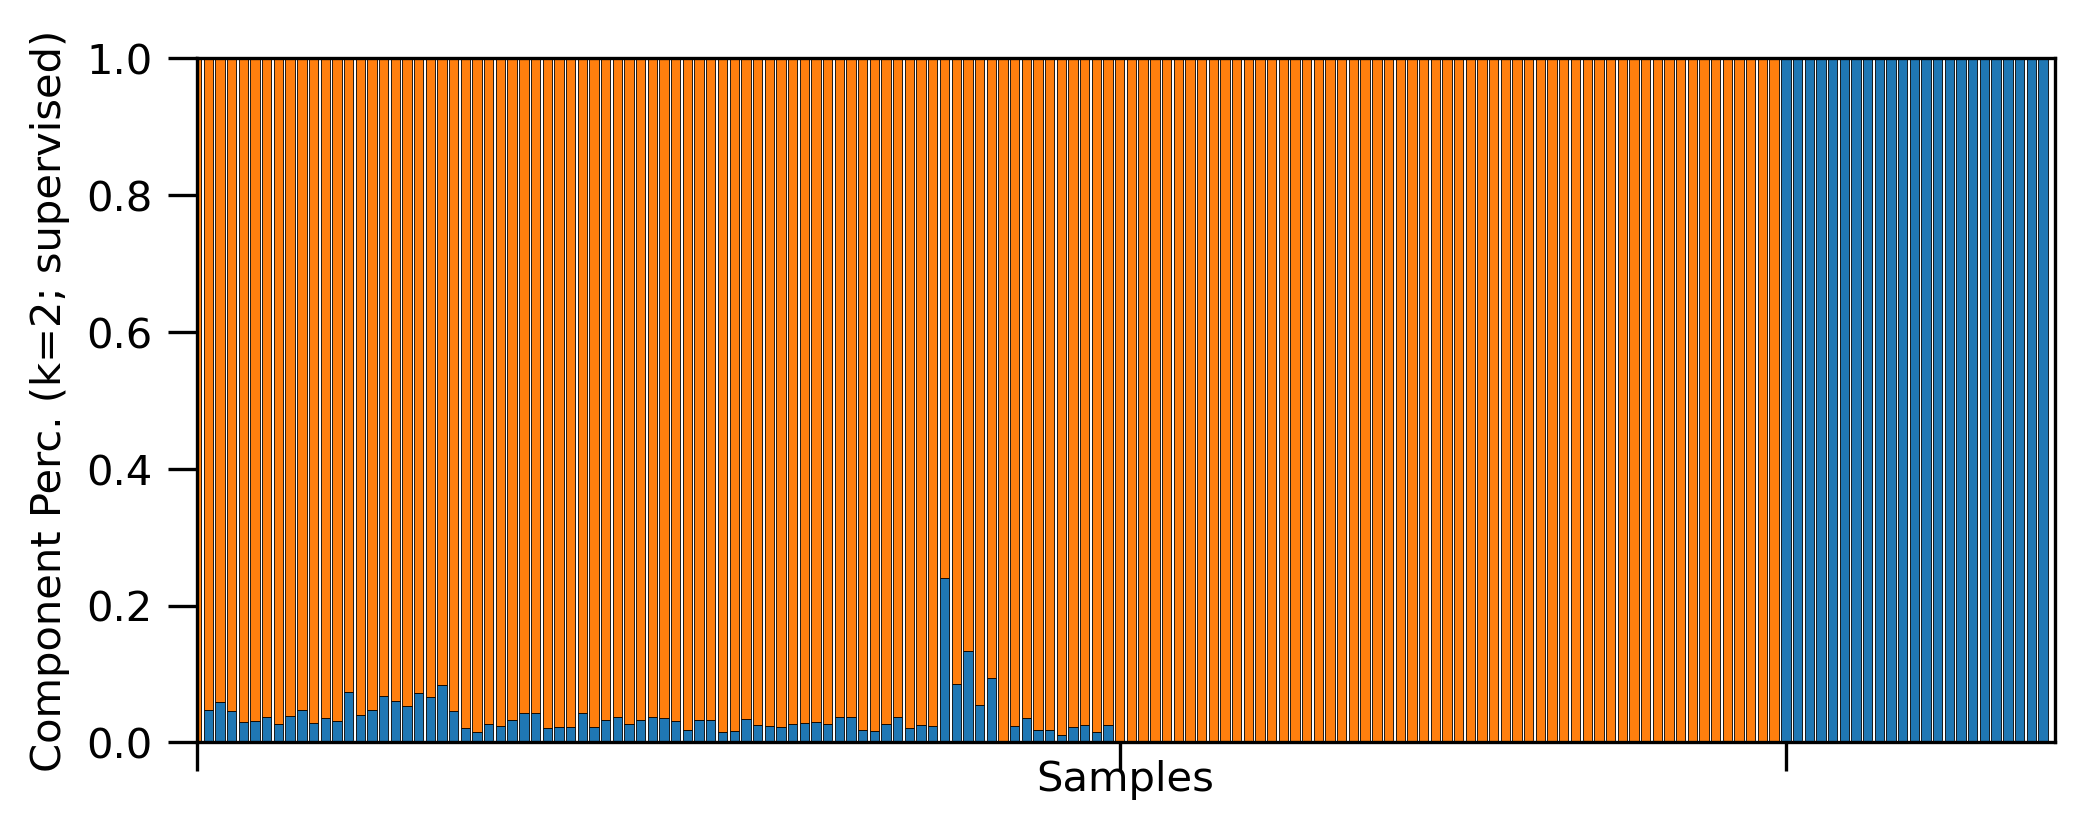

In [171]:
#read in samples
samples=[]
with open("../ingroup_samples.list", 'r') as f:
    samples = f.read().splitlines()

figure(figsize=(7, 3), dpi=300)

#set x range    
x=list(range(0, len(adm_df)))

#set range of ks to be investigated
k=2

adm_df=pd.read_csv("ingroup_maf05_ld_filtered_thinned10k.{}.Q".format(k), sep=" ", header=None)
adm_df["sample_name"]=samples

info_df=pd.read_csv("../../../data/seq_and_sample_docs/all_sh_sb_sample_data.csv", sep=",") 

#merge the dataframes
adm_df=adm_df.merge(info_df, how='left', on='sample_name')

#get pca kmeans groups and add
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
adm_df=adm_df.merge(pca_df[["sample_name", "kmeans_group"]], how='left', on='sample_name')


#adm_df=adm_df.sort_values(by=["presumed_species", "country"])
adm_df=adm_df.sort_values(by=["kmeans_group", "country"])
adm_df=adm_df.reset_index(drop=True)

#adm_df

bottom=[0]*len(adm_df)
for p_comp in range(0, k):
    plt.bar(x, adm_df[p_comp], bottom=bottom, edgecolor="black", linewidth=0.2)
    bottom=bottom+adm_df[p_comp]

#plt.xlabel(adm_df["sample_name"])
plt.ylabel("Component Perc. (k={}; supervised)".format(k))
plt.xlabel("Samples")
plt.tight_layout()
plt.xlim(0,len(adm_df))
plt.ylim(0,1)
plt.xticks(xticks)
plt.tick_params(labelbottom=False, length=7) 

plt.savefig("k{}_supervised.svg".format(k))
plt.savefig("k{}_supervised.png".format(k), dpi=300)

plt.show()
plt.close()

# Fst

In [180]:
Path("{}/fst".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/fst".format(results_dir))

In [91]:
filtered_callset=allel.read_vcf('../filter_genotypes/annotated_snps.vcf')

In [149]:
gt=allel.GenotypeArray(filtered_callset['calldata/GT'])
snv_ids=filtered_callset['variants/ID']

In [94]:
#get kmeans_pop_idxs

#now get an index for each sample/population
samples = list(filtered_callset["samples"])

#read in pca_df since it has the pca kmeans groups
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")

#initiate list that will store the vcf idx for each sample in relation to the pca k group
kmeans_pop_idxs = defaultdict(list)   

for k in pca_df["kmeans_group"].unique():
    k_samples=list(pca_df[pca_df["kmeans_group"] == k]["sample_name"])
    
    for k_sample in k_samples:
        kmeans_pop_idxs[k].append(samples.index(k_sample))

## Fst between species and populations from kmeans groups

In [192]:
for k_pop1, k_pop2 in combinations(pca_df["kmeans_group"].unique(), 2):
    fst, se, vb, vj = allel.average_weir_cockerham_fst(gt, 
                                                       [kmeans_pop_idxs[k_pop1], kmeans_pop_idxs[k_pop2]], 
                                                       50000)

    #display values (call back from k_pop_labels designated in the PCA section)
    print("Fst {} vs {} = {} (SE {})".format(k_pop_labels[k_pop1], k_pop_labels[k_pop2], fst, se))

/master/nplatt/sch_hae_scan/envs/jupyterlab_postproc/lib/python3.8/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/master/nplatt/sch_hae_scan/envs/jupyterlab_postproc/lib/python3.8/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *


Fst Sb vs Sh (NW) = 0.7424652298008534 (SE 0.005157663516202352
Fst Sb vs Sh (SE) = 0.7910731776293033 (SE 0.0034120929595628
Fst Sh (NW) vs Sh (SE) = 0.16227186652769857 (SE 0.0073946955826676404


## Get FST between ADM "ref" populations

In [135]:
#get fst between "ref" samples

#read ref samples to an array (from ADM analyses above)
sh_ref_samples = np.genfromtxt("{}/admixture/sh_ref.list".format(results_dir), delimiter=',', dtype=str)
sb_ref_samples = np.genfromtxt("{}/admixture/sb_ref.list".format(results_dir), delimiter=',', dtype=str)

#get ac counts from each ref pop
sh_ref_sample_idxs=[]
for ref_sample in sh_ref_samples:
    sh_ref_sample_idxs.append(samples.index(ref_sample))
    
sb_ref_sample_idxs=[]
for ref_sample in sb_ref_samples:
    sb_ref_sample_idxs.append(samples.index(ref_sample))


#run fst
a, b, c = allel.weir_cockerham_fst(gt, 
                                   [sb_ref_sample_idxs, sh_ref_sample_idxs])

fsts = (np.sum(a, axis=1) / (np.sum(a, axis=1) + np.sum(b, axis=1) + np.sum(c, axis=1)))

/master/nplatt/sch_hae_scan/envs/jupyterlab_postproc/lib/python3.8/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
<ipython-input-135-003feaeded01>:21: RuntimeWarning: invalid value encountered in true_divide
  fsts = a / (a + b + c)


In [164]:
len(a) == len(fsts)

True

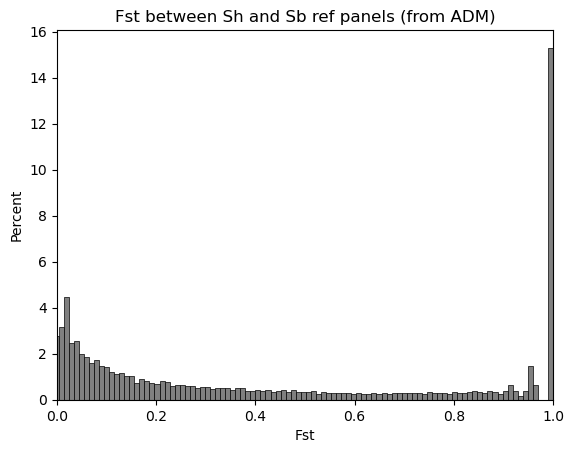

In [179]:
plt.hist(fsts, 200, density=True, edgecolor='black', linewidth=0.5, color="grey")
plt.xlabel("Fst")
plt.ylabel("Percent")
plt.title("Fst between Sh and Sb ref panels (from ADM)")
plt.xlim(0,1)
plt.show()

## Get SNPs with high fst between ref. populations

In [165]:
len(fsts[fsts==1])

1773541

In [168]:
snvs_fst_eq_1=snv_ids[fsts==1]
np.savetxt("snvs_fst_eq_1.list", snvs_fst_eq_1, delimiter=',', fmt="%s")

In [ ]:
#extract these variants with vcftools

%%bash
#thin the vcf file

vcftools \
    --vcf ../filter_genotypes/ingroup_maf05.vcf \
    --snps snvs_fst_eq_1.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >ingroup_maf05_fst_between_ref_pops_eq_1.vcf

#now ld filter
plink \
    --vcf ingroup_maf05_fst_between_ref_pops_eq_1.vcf \
    --allow-extra-chr \
    --double-id \
    --indep-pairwise 25 5 0.20 \
    --out ingroup_maf05_fst_between_ref_pops_eq_1_ld_filtered

#remove linked snps
vcftools \
    --vcf ingroup_maf05_fst_between_ref_pops_eq_1.vcf \
    --exclude ingroup_maf05_fst_between_ref_pops_eq_1_ld_filtered.prune.out \
    --recode \
    --recode-INFO-all \
    --stdout \
    >ingroup_filtered_snp_panel.vcf

In [172]:
del filtered_callset
del gt

# Caclulate hybrid index

In [186]:
Path("{}/hybrid_index".format(results_dir)).mkdir(parents=True, exist_ok=True)

In [51]:
os.chdir("{}/hybrid_index".format(results_dir))

In [190]:
%%bash 

#further "unlink" snps 
vcftools \
    --vcf ../fst/ingroup_filtered_snp_panel.vcf \
    --thin 10000 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >ingroup_filtered_snp_panel_thinned10kb.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../fst/ingroup_filtered_snp_panel.vcf
	--recode-INFO-all
	--thin 10000
	--recode
	--stdout

After filtering, kept 159 out of 159 Individuals
Outputting VCF file...
After filtering, kept 20608 out of a possible 40939 Sites
Run Time = 18.00 seconds


In [191]:
%%bash

#create a "ploidy" for entroyp
grep "#" ingroup_filtered_snp_panel_thinned10kb.vcf | tail -n 1 | cut -f10- | sed 's/\t/\n/g' | awk '{print "2"}' >ploidy_inds.txt


In [ ]:
%%bash

Rscript ~/sch_hae_scan/bin/mixedploidy-entropy/auxfiles/inputdataformat.R ingroup_filtered_snp_panel_thinned10kb.vcf

```
Required -                                                                                     
-i Infile with genetic data for the population (.mpgl)             
-n Ploidy level for individuals (1, 2, 3, 4, 6)                                                                                                                                               
  (a single number indicating same ploidy for all individuals                                  
OR Infile with ploidy for each individual on a new line        
OR Infile with ploidy for each individual in a new line and each locus in a new column)        
-m BOOL infile is in genotype likelihood format [default = 1]      
-l Number of MCMC steps for the analysis [default = 10000]                                                                                                                                    
-b Discard the first n MCMC samples as a burn-in [default = 5000]                              
-t Thin MCMC samples by recording every nth value [default = 5]   
-k Number of population clusters [default = 2]                                                 
-o HDF5 format outfile with .hdf5 suffix [default = mcmcout.hdf5]                              
                                                                                                                                                                                              
Optional -                                                                                     
-q File with expected starting values for admixture proportions   
-Q BOOL estimate intra- and interspecific ancestry and marginal q [default = 0]
-w BOOL Output includes population allele frequencies [default = 0]                            
-e Probability of sequence error, set to '9' for locus-specific error rates [default = 0] (only required if infile is not in genotype likelihood format)
-s Scalar for Dirichlet init. of q, inversly prop. to variance [default = 1]
-p +/- proposal for ancestral allele frequency [default = 0.1]    
-f +/- proposal for Fst [default = 0.01]
-y +/- proposal for gamma [default = 0.2]                                                      
-a +/- proposal for alpha [default = 0.1]
-r INT seed for random number generator [default = clock]
-D BOOL flag to calculate DIC or WAIC estimates [default = 0, DIC]
```

In [ ]:
%%bash

echo -e "chain\tseed" >seeds.log

for CHAIN in $(seq -w 0 7); do
    SEED=$RANDOM
    
    echo -e $CHAIN"\t"$SEED >>seeds.log
    
    ~/sch_hae_scan/bin/entropy/bin/entropy \
        -i ingroup_filtered_snp_panel_thinned10kb.mpgl \
        -n 2 \
        -k 2 \
        -Q 1 \
        -q qk2inds.txt \
        -l 50000 \
        -b 500 \
        -t 10 \
        -o chain_$CHAIN.hdf5 \
        -r $SEED \
        &> chain_$CHAIN.log &
done

In [ ]:
%%bash

#check for convergence
Rscript ~/sch_hae_scan/bin/mixedploidy-entropy/auxfiles/assesconvergence.R chain_0.hdf5


In [200]:
%%bash 

#calculate q and Q12
~/sch_hae_scan/bin/entropy/bin/estpost.entropy \
    -p q \
    -c 0.95 \
    -s 0 \
    -o q_95civ.csv \
    $(ls chain_*.hdf5)

~/sch_hae_scan/bin/entropy/bin/estpost.entropy \
    -p Q \
    -c 0.95 \
    -s 0 \
    -o q12_95civ.csv \
    $(ls chain_*.hdf5)

file = chain_0.hdf5
file = chain_1.hdf5
file = chain_2.hdf5
file = chain_3.hdf5
file = chain_4.hdf5
file = chain_5.hdf5
file = chain_6.hdf5
file = chain_7.hdf5
parameter dimensions for q: ind = 159, populations = 2, samples = 4950, chains = 8
file = chain_0.hdf5
file = chain_1.hdf5
file = chain_2.hdf5
file = chain_3.hdf5
file = chain_4.hdf5
file = chain_5.hdf5
file = chain_6.hdf5
file = chain_7.hdf5
parameter dimensions for Q: ind = 159, populations = 2, samples = 4950, chains = 8


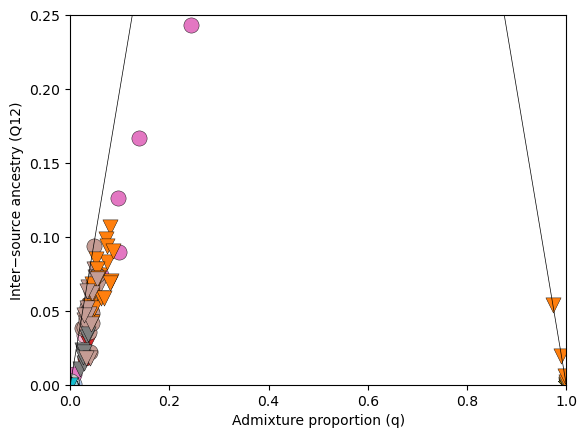

In [290]:
# #plot (triangle)

# #read in data
# q_df=pd.read_csv("q_95civ.csv", sep=",")
# Q_df=pd.read_csv("q12_95civ.csv", sep=",")

# #read in vcf to get the samples
# vcf_reader = vcf.Reader(open('ingroup_filtered_snp_panel_thinned10kb.vcf', 'r'))
# samples=vcf_reader.samples

# #add sample names (twice for q (pop1, pop2) and three times for Q (p1-p1, p2-p1, p2-2))
# q_df["sample_id"]=samples + samples
# Q_df["sample_id"]=samples + samples + samples

# #subsample only q12
# q12_df=Q_df[Q_df["param"].str.contains("_anc_2-1")]

# #subsample only p0
# p0_q=q_df[q_df["param"].str.contains("_pop_0")]

#plot
plt.plot([0, 0.5, 1], [0, 1, 0], c="black", linewidth=0.5)

for q,  q12,  sample_id in zip(p0_q["mean"], q12_df["mean"], p0_q["sample_id"]):
    country=info_df[info_df["sample_name"]==sample_id]["country"].values[0]
    sp=info_df[info_df["sample_name"]==sample_id]["presumed_species"].values[0]
    
    marker=markers[sp]
    color=colors[country]
    
    plt.scatter(q, q12, marker=marker, color=color, edgecolor="black", linewidths=0.3, s=120, alpha=1)
    
plt.ylabel("Inter−source ancestry (Q12)")
plt.xlabel("Admixture proportion (q)")
plt.xlim(0,1)
plt.ylim(0,0.25)
plt.show()

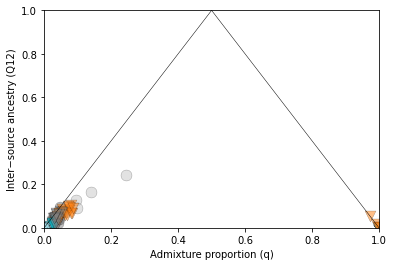

In [57]:
#plot (triangle)

#read in data
q_df=pd.read_csv("q_95civ.csv", sep=",")
Q_df=pd.read_csv("q12_95civ.csv", sep=",")

#read in vcf to get the samples
vcf_reader = vcf.Reader(open('ingroup_filtered_snp_panel_thinned10kb.vcf', 'r'))
samples=vcf_reader.samples

#add sample names (twice for q (pop1, pop2) and three times for Q (p1-p1, p2-p1, p2-2))
q_df["sample_id"]=samples + samples
Q_df["sample_id"]=samples + samples + samples

#subsample only q12
q12_df=Q_df[Q_df["param"].str.contains("_anc_2-1")]

#subsample only p0
p0_q=q_df[q_df["param"].str.contains("_pop_0")]

#plot
plt.plot([0, 0.5, 1], [0, 1, 0], c="black", linewidth=0.5)

for q,  q12,  sample_id in zip(p0_q["mean"], q12_df["mean"], p0_q["sample_id"]):
    country=info_df[info_df["sample_name"]==sample_id]["country"].values[0]
    sp=info_df[info_df["sample_name"]==sample_id]["presumed_species"].values[0]
    
    marker=markers[sp]
    color=colors[country]
    
    plt.scatter(q, q12, marker=marker, color=color, edgecolor="black", linewidths=0.3, s=120, alpha=0.5)
    
plt.ylabel("Inter−source ancestry (Q12)")
plt.xlabel("Admixture proportion (q)")
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig("q_q12.svg")
plt.savefig("q_q12.png", dpi=300)

plt.show()

In [71]:
q_df.loc[(q_df["mean"] <0.4)].sort_values(by=["mean"], ascending=False)


,param,mean,median,ci_0.950_LB,ci_0.950_UB,sample_id
9,q_ind_9_pop_0,0.243077,0.243082,0.237795,0.248475,Sh_NG_eb_6_2
11,q_ind_11_pop_0,0.138892,0.138882,0.134450,0.143380,Sh_NG_ed_3_2
13,q_ind_13_pop_0,0.098076,0.098052,0.093762,0.102463,Sh_NG_kw_1_10
10,q_ind_10_pop_0,0.096466,0.096453,0.092658,0.100329,Sh_NG_ed_1_3
148,q_ind_148_pop_0,0.086279,0.086270,0.082370,0.090237,ssp_cdivoire_raviart_99
...,...,...,...,...,...,...
70,q_ind_70_pop_0,0.000008,0.000001,0.000000,0.000066,sha_madag_belesalampy_77
160,q_ind_1_pop_1,0.000008,0.000001,0.000000,0.000063,Sb_NG_au_2.10
159,q_ind_0_pop_1,0.000007,0.000001,0.000000,0.000055,Sb_NG_au_1.2
165,q_ind_6_pop_1,0.000007,0.000001,0.000000,0.000056,Sb_NG_be_1.3


# Mantel test

In [3]:
Path("{}/mantel".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/mantel".format(results_dir))

In [127]:
#read in sample info
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

#get the pca kmeans groups
pca_df=pd.read_csv("{}/results/pca/pca_df.csv".format(proj_dir), sep=",")
pca_df=pca_df[["sample_name", "kmeans_group", "kmeans_label"]]

#add to the sample info
info_df=info_df.merge(pca_df, how='right', on='sample_name')

In [133]:
#samples with no lat/lon info cause major problems will need to exclude downstream
samples_with_latlon=list(info_df.loc[ ( (info_df['lat'].notnull()) | (info_df['lon'].notnull())) ]["sample_name"])
len(samples_with_latlon)

130

## Calculate genetic distances 
calculated wtih `VCF2Dis` from https://github.com/BGI-shenzhen/VCF2Dis.  Cloned into `sch_hae_scan/bin`

In [5]:
#get the genetic data
vcf_reader = vcf.Reader(open('../filter_genotypes/ingroup_indv_and_site_filt.vcf', 'r'))
#get the sample order
samples=vcf_reader.samples

#get kmeans index of samples
kmeans_pop_idxs = defaultdict(list)   

for k in info_df["kmeans_label"].unique():
    k_samples=list(info_df[pca_df["kmeans_label"] == k]["sample_name"])
    
    for k_sample in k_samples:
        kmeans_pop_idxs[k].append(samples.index(k_sample))

In [ ]:
%%bash

~/sch_hae_scan/bin/VCF2Dis/bin/VCF2Dis -InPut ../filter_genotypes/ingroup_indv_and_site_filt.vcf -OutPut ingroup_p_dis_mat.tsv

In [24]:
#read in distance matrix
gen_df = pd.read_table("ingroup_p_dis_mat.tsv", sep="\t", header=None, index_col=0, skiprows=[0])

#VCF2Dis only keeps the first 20 chars in the sample name... so need to re-header
gen_df.index=samples
gen_df.columns=samples
gen_df.to_csv("ingroup_p_dis_mat_df.csv", sep=",")

## Get geo distances

In [87]:
km_dists=np.array([])
for s1 in samples:
    s1_lat=info_df.loc[info_df["sample_name"] == s1]["lat"].values[0]
    s1_lon=info_df.loc[info_df["sample_name"] == s1]["lon"].values[0]
    
    for s2 in samples:
        s2_lat=info_df.loc[info_df["sample_name"] == s2]["lat"].values[0]
        s2_lon=info_df.loc[info_df["sample_name"] == s2]["lon"].values[0]
        
        km_dists=np.append(km_dists, haversine((s1_lat, s1_lon), (s2_lat, s2_lon)))
        
#reshape into a 2d matrix
km_dists.shape=(len(samples), len(samples))

#convert to a df
km_df=pd.DataFrame(data=km_dists, columns=samples, index=samples)
km_df.to_csv("ingroup_km dist.csv", sep=",")
km_df

,Sb_NG_au_1.2,Sb_NG_au_2.10,Sb_NG_au_2.13,Sb_NG_au_2.5,Sb_NG_au_2.6,Sb_NG_be_1.10,Sb_NG_be_1.3,Sb_NG_be_1.5,Sb_NG_en_1.1,Sh_NG_eb_6_2,...,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_niger_libore_173,ssp_zambia_kafue_71
Sb_NG_au_1.2,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
Sb_NG_au_2.10,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
Sb_NG_au_2.13,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
Sb_NG_au_2.5,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
Sb_NG_au_2.6,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_167,832.344503,832.344503,832.344503,832.344503,832.344503,868.808416,868.808416,868.808416,965.941774,1015.693312,...,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,1.849721,4322.066439
ssp_niger_libore_168,832.344503,832.344503,832.344503,832.344503,832.344503,868.808416,868.808416,868.808416,965.941774,1015.693312,...,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,1.849721,4322.066439
ssp_niger_libore_169,834.194103,834.194103,834.194103,834.194103,834.194103,870.647892,870.647892,870.647892,967.783870,1017.525832,...,2.158047,2.158047,2.158047,1.849721,2.158047,1.849721,1.849721,0.000000,0.000000,4323.887609
ssp_niger_libore_173,834.194103,834.194103,834.194103,834.194103,834.194103,870.647892,870.647892,870.647892,967.783870,1017.525832,...,2.158047,2.158047,2.158047,1.849721,2.158047,1.849721,1.849721,0.000000,0.000000,4323.887609


## Mantel Tests

In [ ]:
# skbio.stats.distance.mantel(x, y, 
#                             method='pearson', 
#                             permutations=999, 
#                             alternative='two-sided', 
#                             strict=True, 
#                             lookup=None)


#mantel test from all exome samples:
stats.distance.mantel(gen_df, km_df, permutations=1000)

In [159]:
# Need to do 4 comparisons
# Sb
# Sh
# NW
# SE

sb_idx=kmeans_pop_idxs["Sb"]
nw_idx=kmeans_pop_idxs["Sh (NW)"]
se_idx=kmeans_pop_idxs["Sh (SE)"]
sh_idx=nw_idx + se_idx

Mantel test - Sbovis: r2=0.67, p=0.001, n=16
Mantel test - Sh (NW): r2=0.02, p=0.794, n=67
Mantel test - Sh, SE: r2=0.56, p=0.001, n=47


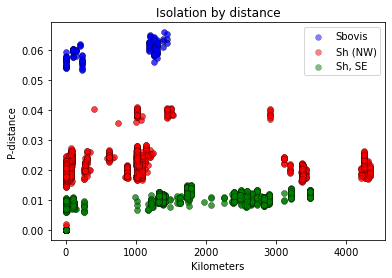

In [185]:
# (sh_idx, "yellow","Shaem")
                   

for idx, color, label in [(sb_idx, "blue", "Sbovis"),
                          (nw_idx, "red", "Sh (NW)"),
                          (se_idx, "green", "Sh, SE") ]:
    
    #subsample genetic and physical distance matricies
    g=gen_df.iloc[idx, idx]
    k=km_df.iloc[idx, idx]

    #get rid of anything that didn't have lat lon
    mask=k.index.isin(samples_with_latlon)
    g=g.loc[mask, mask]
    k=k.loc[mask, mask]

    #conduct the mantel test
    r2, p, n = mantel(g, k, permutations=1000)
    print("Mantel test - {}: r2={:.2f}, p={:.3f}, n={}".format(label, r2, p, n))
    #add points to scatter plot
    gs=g.values.flatten()
    ks=k.values.flatten()
    plt.scatter(ks, gs, alpha=0.5, color=color, edgecolors="black", linewidth=0.3, label=label)

    
plt.legend()
plt.title("Isolation by distance")
plt.xlabel("Kilometers")
plt.ylabel("P-distance")
plt.show()

# Pop structure with lab and simulated hybrids

## force dataset "down" to sites that pass QC with the Rey et al. 2021 F1 sample

In [ ]:
#run code/filter_gvcf_rey2021.sh to get a filtered set of variants at only positions that can be genomtyped from the Rey et al. 2021 Lab F1 sample

### pca

In [3]:
Path("{}/pca_w_rey_f1".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/pca_w_rey_f1".format(results_dir))

In [4]:
%%bash

plink \
    --vcf ../filter_genotypes_for_f1/rey2021_maf05_ld_filtered.vcf \
    --pca \
    --double-id \
    --allow-extra-chr \
    --out pca

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to pca.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out pca
  --pca
  --vcf ../filter_genotypes_for_f1/rey2021_maf05_ld_filtered.vcf

128540 MB RAM detected; reserving 64270 MB for main workspace.
--vcf: pca-temporary.bed + pca-temporary.bim + pca-temporary.fam written.
9554 variants loaded from .bim file.
193 people (0 males, 0 females, 193 ambiguous) loaded from .fam.
Ambiguous sex IDs written to pca.nosex .
Using up to 47 threads (change this with --threads).
Before main variant filters, 193 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.927906.
9554 variants and 193 peop

In [42]:
pca_df=pd.read_csv("pca.eigenvec", sep=" ", header=None)
pca_df.columns=["sample_name", "x"] + list(range(1, 21))
pca_df=pca_df.drop("x", axis=1)

# #now add sample info (including location data)
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

#merge the dataframes
pca_df=pca_df.merge(info_df, how='left', on='sample_name')

#set marker colors based on the country (limit to 20)
colors={}

i=0
for country in sorted(pca_df["country"].unique()):
    colors[country]=cm.tab20(i)
    i+=1

#set marker shapes based on PRESUMED species
markers = { 's_haematobium'  : "o", 
            's_sp'           : "v",
            's_bovis'        : "X",
            's_intercalatum' : "*", 
            's_guiniensis'   : "*",
            's_margrebowiei' : "*", 
            's_matthei'      : "*",
            'f1'             : "*" }

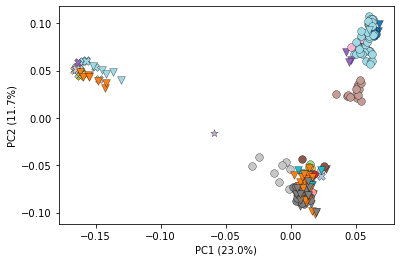

In [50]:
#plot the results
fig, ax = plt.subplots()

for index, row in pca_df.iterrows():
    x=row[1]
    y=row[2]
    marker=markers[row["presumed_species"]]
    color=colors[row["country"]]
    if markers[row["presumed_species"]] == 'f1':
        plt.scatter(x, y, marker=marker, color=color, edgecolor="black", linewidths=0.3, s=500)
    else:
        plt.scatter(x, y, marker=marker, color=color, edgecolor="black", linewidths=0.3, s=60)

# #set title
# num_snvs="^"
# plt.title("{} SNPs (MAF05, LD)".format(num_snvs))

#set x label (eigen 1)
eigen_vals=[line.strip() for line in open("pca.eigenval", 'r')]

pc1=eigen_vals[0]
plt.xlabel("PC1 ({:.1f}%)".format(float(pc1)))

#set x label (eigen 2)
pc2=eigen_vals[1]
plt.ylabel("PC2 ({:.1f}%)".format(float(pc2)))

# #add rectangles
# for k in [0,1,2]:
#     x1=pca_df[pca_df["kmeans_group"]==k][1].min()
#     x2=pca_df[pca_df["kmeans_group"]==k][1].max()

#     y1=pca_df[pca_df["kmeans_group"]==k][2].min()
#     y2=pca_df[pca_df["kmeans_group"]==k][2].max()

#     rect = mpatches.Rectangle((x1-.01, y1-.01), (x2-x1)+.02, (y2-y1)+.02, linewidth=1, edgecolor='grey', facecolor='none')
    
#     # Add the patch to the Axes
#     ax.add_patch(rect)

# #make legend for countries
# country_patches=[]
# for country in colors.keys():
#     country_patch=mpatches.Patch(facecolor=colors[country], 
#                          edgecolor="black", 
#                          label=country.title().replace("_", " "),
#                          linewidth=0.3)
#     country_patches.append(country_patch)
    
# #country_legend = plt.legend(title="Country", handles=country_patches, scatterpoints=1, bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=2)
# country_legend = plt.legend(title="Country", handles=country_patches, scatterpoints=1, loc='upper left', ncol=3, prop={'size': 8}, edgecolor="black", fancybox=False, shadow=True)

# plt.gca().add_artist(country_legend)

# #make legend for species
# ssp_marker = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='v',
#                           markersize=8, markeredgewidth=0.5, label='${S. sp.}$')
# ssh_marker = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white",  marker='o',
#                           markersize=8, markeredgewidth=0.5, label='${S. haematobium}$')
# ssb_marker = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='X',
#                           markersize=8, markeredgewidth=0.5, label='${S. bovis}$')

#prop={'size': 8}
#plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker], bbox_to_anchor=(1.05, 0.3))
#plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker], loc='lower left', prop={'size': 8}, edgecolor="black", fancybox=False, shadow=True)


# #add kmeans group annotation
# plt.annotate("Sh (SE)", xy=(0.0282, 0.02))
# plt.annotate("Sh (NW)", xy=(-0.005, -0.0353))
# plt.annotate("Sb",      xy=(-0.195,   0.0))



#save
plt.savefig("rey_pca.png", dpi=300)
plt.savefig("rey_pca.svg")

#display
plt.show()

### Admixture

In [72]:
Path("{}/admixture_w_rey_f1".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/admixture_w_rey_f1".format(results_dir))

In [75]:
%%bash
#thin the vcf file

vcftools \
    --vcf ../filter_genotypes_for_f1/rey2021_maf05_ld_filtered.vcf \
    --thin 10000 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >rey2021_maf05_ld_filtered_thinned10k.vcf


plink \
    --vcf rey2021_maf05_ld_filtered_thinned10k.vcf \
    --out rey2021_maf05_ld_filtered_thinned10k \
    --double-id \
    --recode12 \
    --allow-extra-chr

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to rey2021_maf05_ld_filtered_thinned10k.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out rey2021_maf05_ld_filtered_thinned10k
  --recode 12
  --vcf rey2021_maf05_ld_filtered_thinned10k.vcf

128540 MB RAM detected; reserving 64270 MB for main workspace.
--vcf: rey2021_maf05_ld_filtered_thinned10k-temporary.bed +
rey2021_maf05_ld_filtered_thinned10k-temporary.bim +
rey2021_maf05_ld_filtered_thinned10k-temporary.fam written.
2895 variants loaded from .bim file.
193 people (0 males, 0 females, 193 ambiguous) loaded from .fam.
Ambiguous sex IDs written to rey2021_maf05_ld_filtered_thinned10k.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 193 founders and 0 nonfounders present.
Calculating allele frequencies..


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../filter_genotypes_for_f1/rey2021_maf05_ld_filtered.vcf
	--recode-INFO-all
	--thin 10000
	--recode
	--stdout

After filtering, kept 193 out of 193 Individuals
Outputting VCF file...
After filtering, kept 2895 out of a possible 9554 Sites
Run Time = 3.00 seconds


In [76]:
%%bash

cat rey2021_maf05_ld_filtered_thinned10k.vcf \
    | grep "#" \
    | tail -n1 \
    | cut -f10- \
    | sed 's/\t/\n/g' \
    >ingroup_samples.list

In [ ]:
%%bash

#UNSUPERVISED 
#submit jobs to the cluster
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -p -1023"  

for K in $(seq 1 20); do
    CMD="conda activate ~/sch_hae_scan/envs/admixture; admixture \
        --cv=1000 \
        -j12 \
        rey2021_maf05_ld_filtered_thinned10k.ped \
        $K \
        >adm_$K.log"

    echo $CMD | $QSUB -N rey_adm_k$K -o ~/sch_hae_scan/results/logs/rey_adm_k$K.log -pe smp 12
done

In [78]:
%%bash

#get CV scores when jobs are completed
echo "k,cv" >cv_table.csv
for i in $(seq 1 20); do 
    CV=$(grep "CV error" adm_$i.log | rev | cut -f1 -d" "| rev)
    echo "$i,$CV"
done >>cv_table.csv

In [79]:
cv_df=pd.read_csv("cv_table.csv", sep=",") 

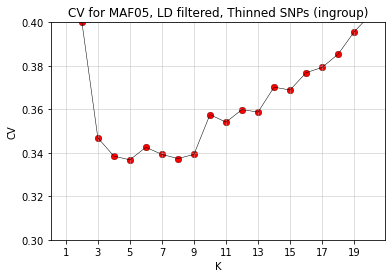

In [89]:
# #plot the cv_table
plt.plot(cv_df["k"], cv_df["cv"], color="black", linewidth=0.5)
plt.scatter(cv_df["k"], cv_df["cv"], 
            marker="o", 
            color="red", 
            edgecolor="black", 
            linewidths=0.3, 
            s=45)
plt.ylim([0.3, 0.4])
plt.xticks(list(range(1,20, 2)))
plt.grid(alpha=0.5)
plt.title("CV for MAF05, LD filtered, Thinned SNPs (ingroup)")
plt.ylabel("CV")
plt.xlabel("K")
plt.savefig("cv.svg")
plt.savefig("cv.png", dpi=300)

plt.show()

In [ ]:
xticks=[]
xlabel_pos=[]
xlabel=[]

# for pca_groups in ["s_bovis", "s_haematobium", "s_sp"]:
#     sp_idxs=adm_df.index[adm_df['presumed_species']==species].tolist()
#     xticks.append(min(sp_idxs))
#     #xticks.append(max(sp_idxs))
#     xlabel_pos=statistics.mean(sp_idxs)
#     xlabel.append(species)

for pcak_group in adm_df["kmeans_group"].unique():
    df_idxs=adm_df.index[adm_df['kmeans_group']==pcak_group].tolist()
    xticks.append(min(df_idxs))
    #xticks.append(max(sp_idxs))
    xlabel_pos=statistics.mean(df_idxs)
    xlabel.append(pcak_group)


Based on these results K4-6 are ideal.

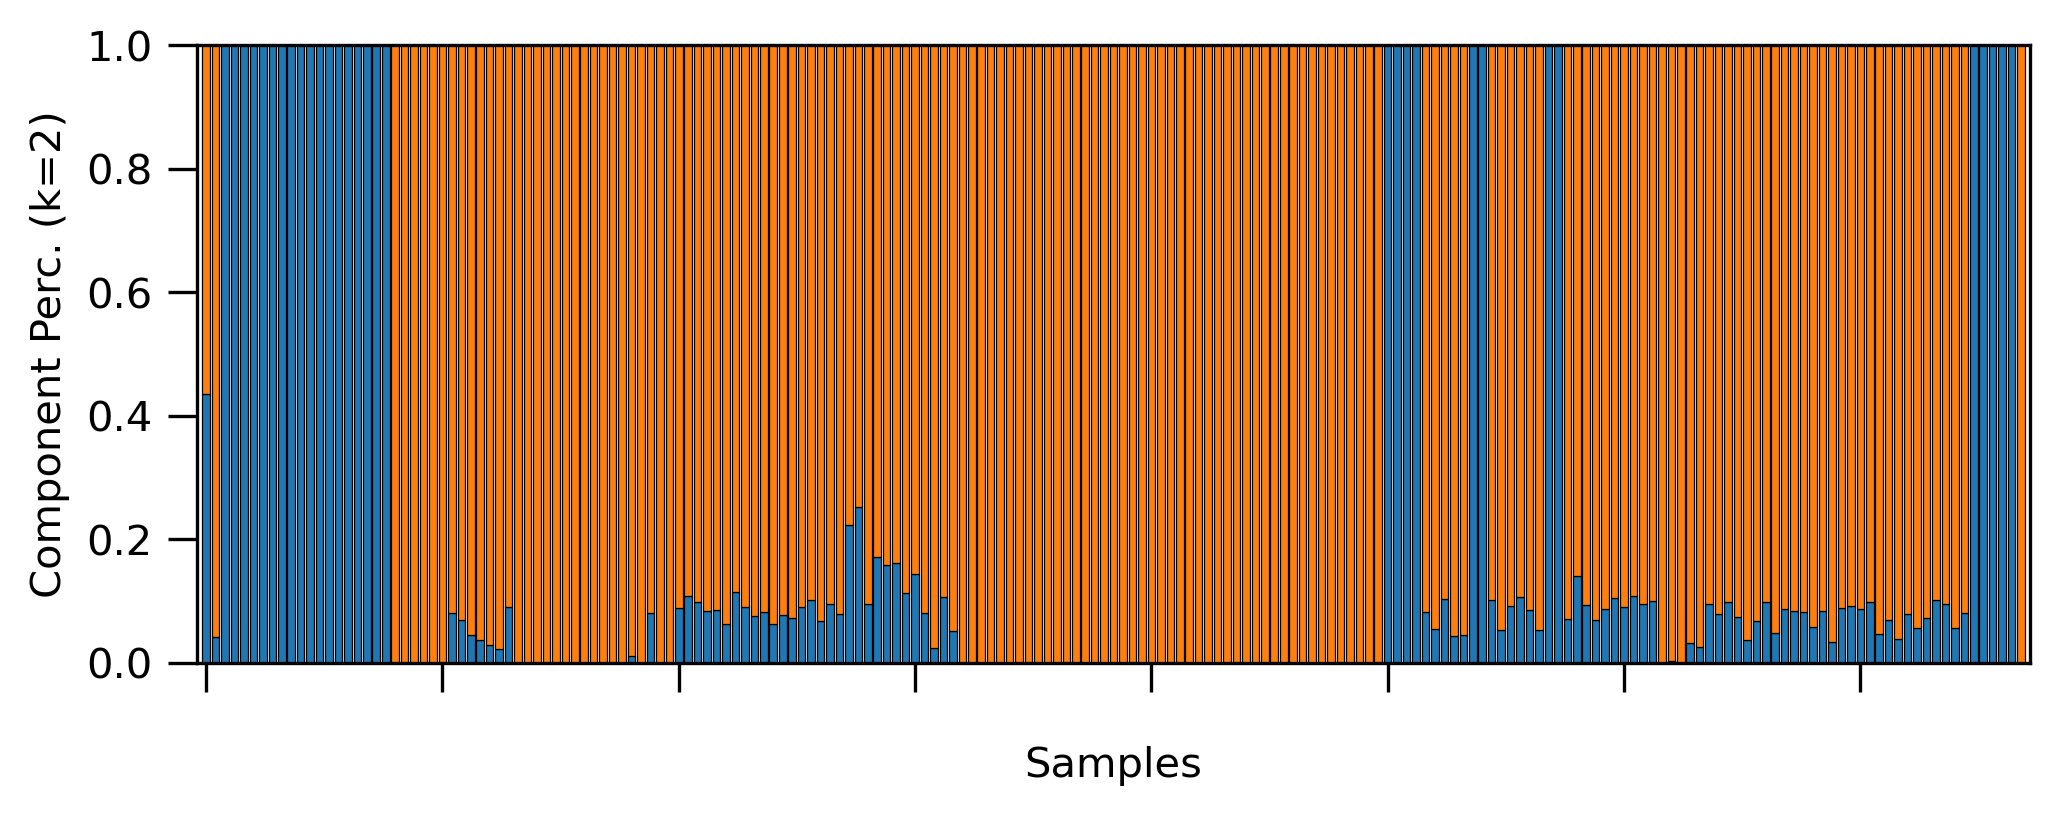

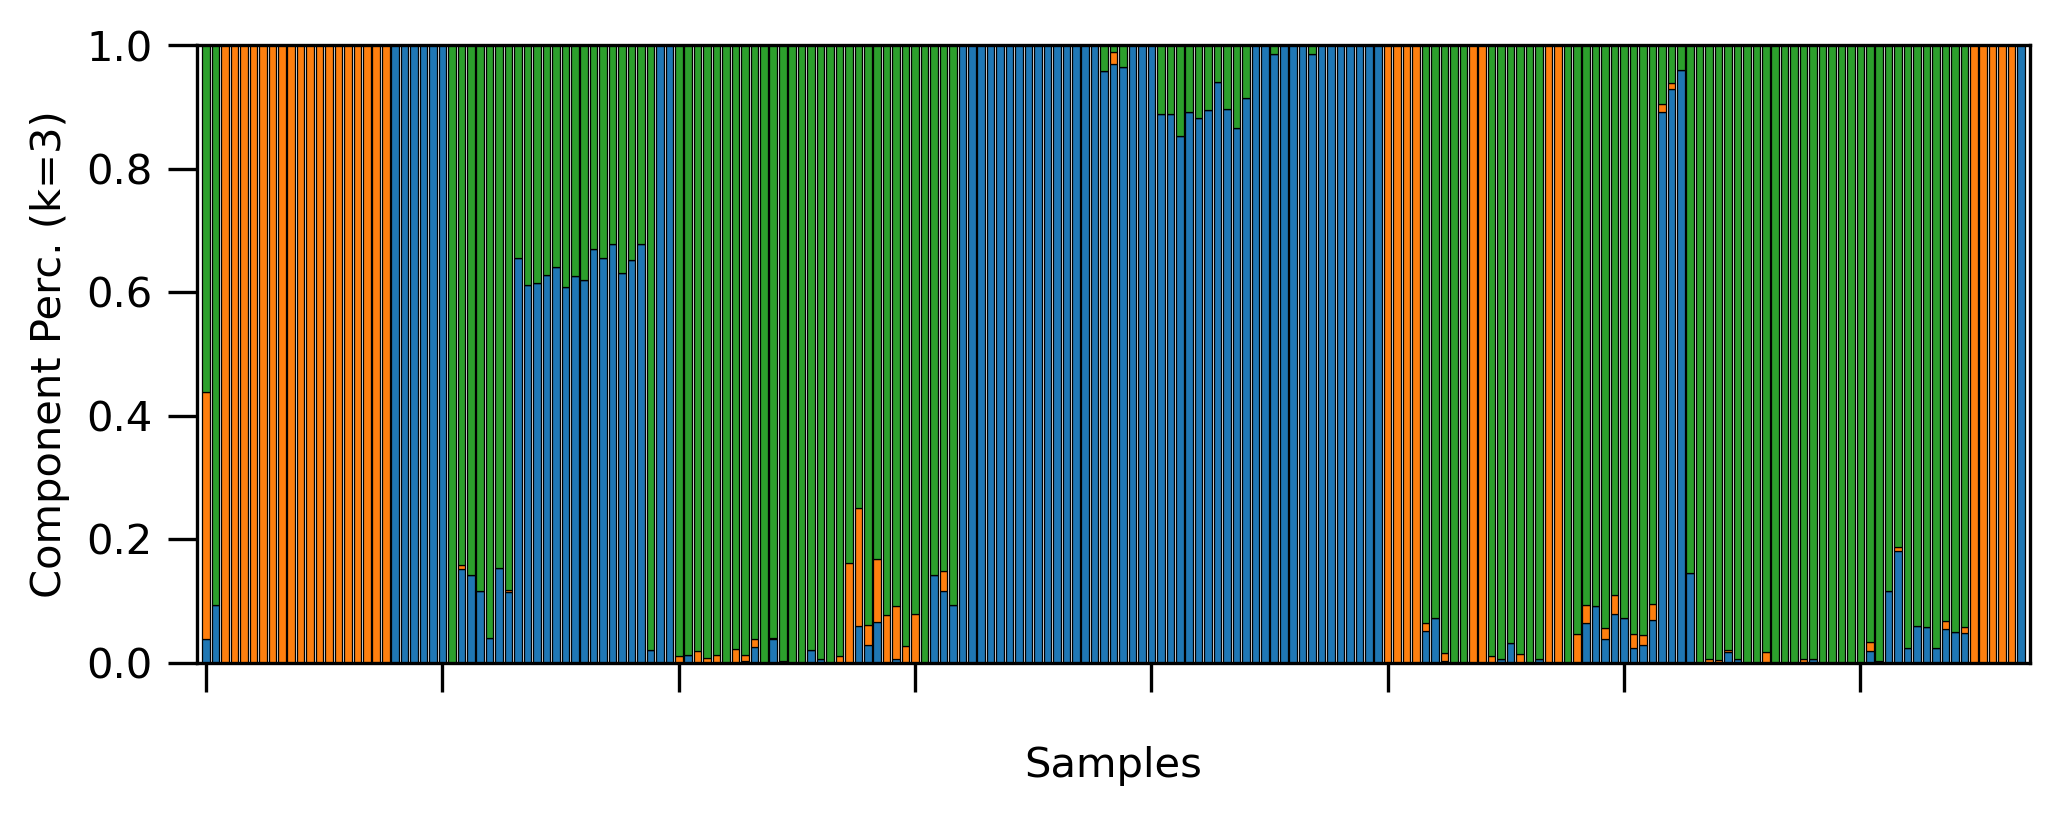

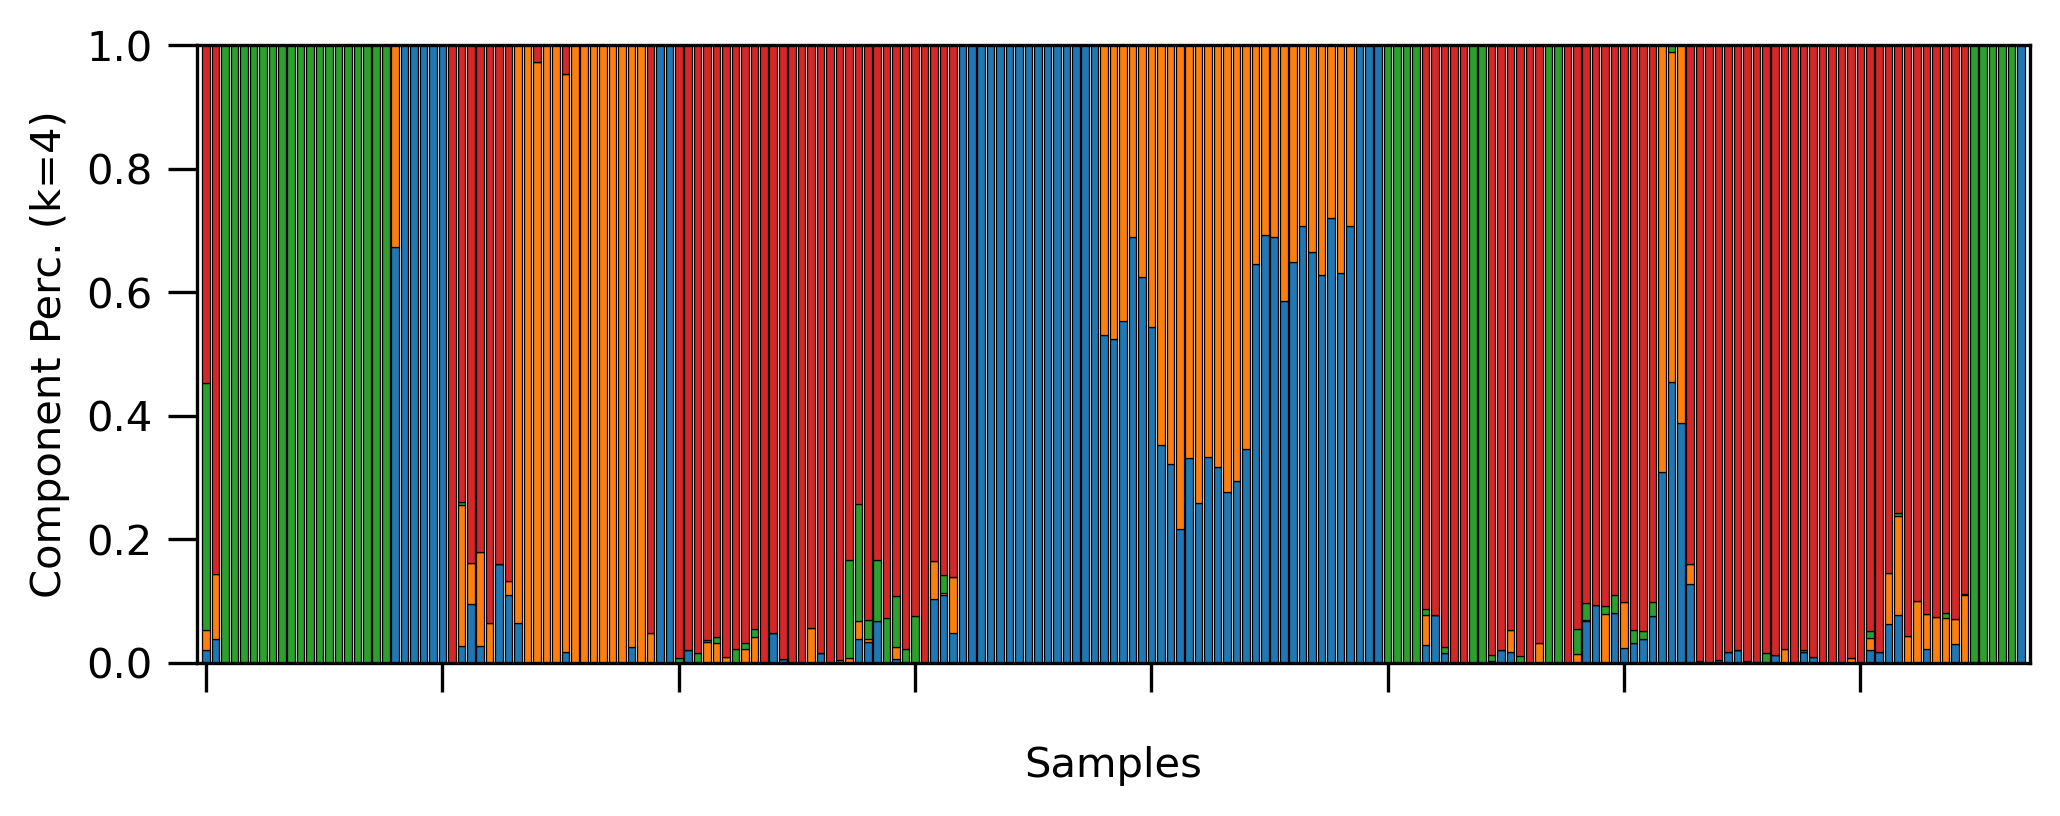

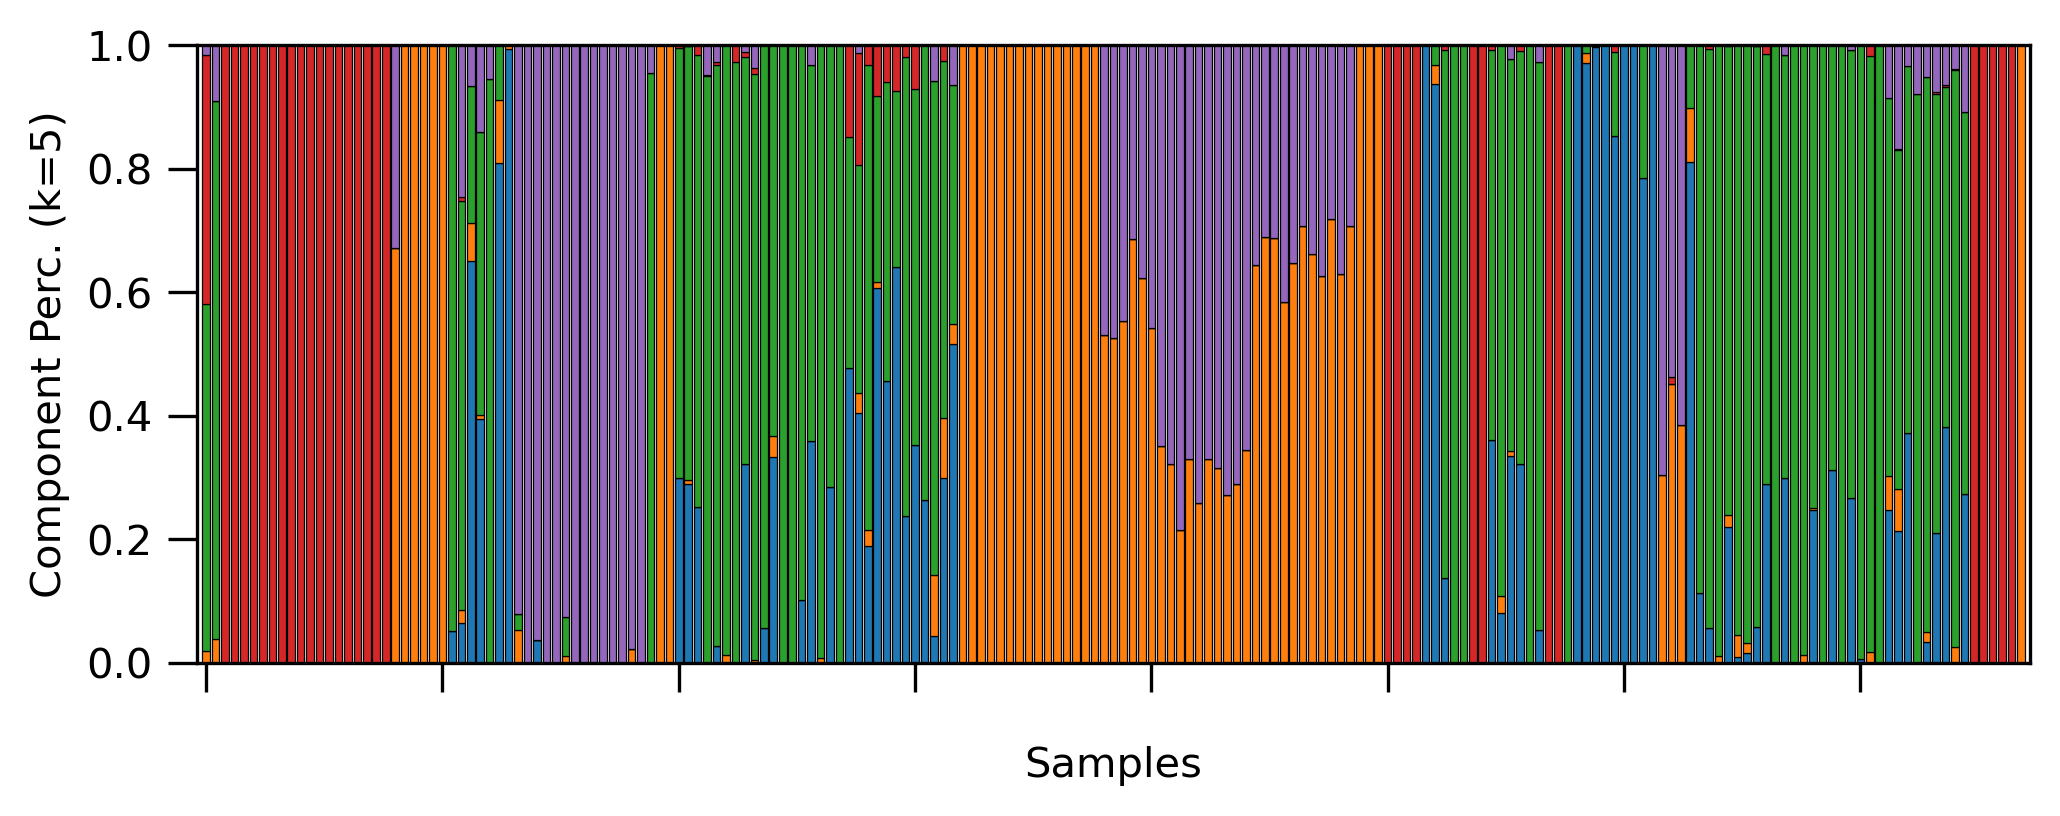

In [93]:
#read in samples
samples=[]
with open("ingroup_samples.list", 'r') as f:
    samples = f.read().splitlines()

#set range of ks to be investigated
ks=[2,3,4,5]

for k in ks:
    figure(figsize=(7, 3), dpi=300)

    adm_df=pd.read_csv("rey2021_maf05_ld_filtered_thinned10k.{}.Q".format(k), sep=" ", header=None)
    adm_df["sample_name"]=samples

    x=list(range(0, len(adm_df)))

    info_df=pd.read_csv("../../data/seq_and_sample_docs/all_sh_sb_sample_data.csv", sep=",") 

    #merge the dataframes
    adm_df=adm_df.merge(info_df, how='left', on='sample_name')

    ##get pca kmeans groups and add
    #pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
    #adm_df=adm_df.merge(pca_df[["sample_name", "kmeans_group"]], how='left', on='sample_name')


    adm_df=adm_df.sort_values(by=["presumed_species", "country"])
    #adm_df=adm_df.sort_values(by=["kmeans_group", "country"])
    adm_df=adm_df.reset_index(drop=True)

    bottom=[0]*len(adm_df)
    for p_comp in range(0, k):
        plt.bar(x, adm_df[p_comp], bottom=bottom, edgecolor="black", linewidth=0.3)
        bottom=bottom+adm_df[p_comp]

    #plt.xlabel(adm_df["sample_name"])
    plt.ylabel("Component Perc. (k={})".format(k))
    plt.xlabel("Samples", labelpad=20)
    plt.tight_layout()
    plt.xlim(-1,len(adm_df))
    plt.ylim(0,1)
    #plt.xticks(xticks)
    plt.tick_params(labelbottom=False, length=7) 
    
    plt.savefig("rey_k{}.svg".format(k))
    plt.savefig("rey_k{}.png".format(k), dpi=600)

    plt.show()
    plt.close()

## Create a in-silico hybrid by merging haplotypes from (one or more) Sb and SE Sh

In [3]:
#to create in silico hybrids 
code/in_silico_f1.sh

In [3]:
#would be great to re-genotype and add these to the data set.

# Jellyfish Kmers

In [188]:
Path("{}/kmers".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/kmers".format(results_dir))

In [ ]:
code/jellyfish_kmers.sh

In [ ]:
#get kmer perc set up like...
#     kmer_freqs[sample][kmer]=freq
kmer_freqs=defaultdict(lambda: defaultdict(lambda: dict()))

for kmer_file in tqdm(glob.glob("*kmer_counts.tsv")):

    sample=kmer_file.replace("_21kmer_counts.tsv", "")
    out_file="{}_kmer.csv".format(sample)

    n_kmers=0
    with open(kmer_file, 'r') as k_f:
        for entry in k_f:
            seq, count = entry.split("\t")
            n_kmers+=int(count)

    with open(kmer_file, 'r') as k_f:
        with open(out_file, 'w') as o_f:

            for entry in k_f:
                seq, count = entry.rstrip().split("\t")
                perc = int(count)/n_kmers
                o_f.write("{},{},{}\n".format(seq, count, perc))
                
    # save as a pickle
    kmer_pickle=dict(kmer_freqs)
    with open('kmer_freqs.pickle', 'wb') as handle:
        pickle.dump(kmer_pickle, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#run a pca